# Statistical analysis of BoligPortal data

In this notebook, we import the already clean and nicely formatted data on accommodations listed on the BoligPortal website and use statistical analysis (including regression modelling) in order to understand which factors affect certain accommodation characteristics (e.g. rent, number of rooms, location).

The focus in this notebook is on getting an understanding rather than building a predictive model, though the model fit is also evaluated. Instead of throwing all sorts of variables at the model, we take a hypothesis-based approch, where we test a series of suppositions derived through common sense and the exploratory analysis we conducted in a separate notebook.

## User input for the analysis

In [ ]:
"""
====================
Providing user input
====================
"""

# Defining file storage location: either "Drive" or "Local"
FileStorageForUse = "Drive"

# If using Google Drive, specify project folder
ProjectFolder = "Projects/IT/BoligPortal insights/"

## Setting things up

We start out by importing all relevant packages for our work and by defining some custom functions that will help us extract the data that we need.

In [ ]:
import datetime as dt
Today = dt.date.today()
print("This notebook was last updated on:", Today)
print("Author: Kiril Boyanov (kirilboyanovbg@gmail.com)")
print("Connect on LinkedIn: https://www.linkedin.com/in/kirilboyanov/")

This notebook was last updated on: 2023-02-21
Author: Kiril Boyanov (kirilboyanovbg@gmail.com)
Connect on LinkedIn: https://www.linkedin.com/in/kirilboyanov/


In [ ]:
%%capture
# Installing packages that may not always be available
# This is mostly relevant for Google Colab
# No special needs as of 01-11-2022

In [ ]:
# Importing relevant packages
import pandas as pd
import pandas.tseries.offsets as offset
import datetime as dt
import numpy as np

# Specifically for working with geodata
import geopy.distance

# Specifically used for data visualisation
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec

# Specifically used for regression analysis
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Setting custom chart size & related other properties
# sns.set(rc = {"figure.figsize":(4, 3)})
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

# Setting custom theme for  plots
DefaultColormapQual = "Set2"
sns.color_palette("Set2", as_cmap = True)
ColorPalette = sns.color_palette("Set2")
ColorPalette.as_hex()

# Setting custom limits for maximum N of rows/cols to print in data previews
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
"""
=======================================
Arranging data storage for the analysis
=======================================
"""

# Creating a universal folder reference to use regardless of chosen storage method
if FileStorageForUse == "Local":
  import os
  AnalysisFolder = os.getcwd() + "/"
  print("The analysis will be run using local data storage.")
  print("The data will be saved in the following directory:")
  print(AnalysisFolder)
elif FileStorageForUse == "Drive":
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount = True)
  AnalysisFolder = "/content/gdrive/MyDrive/" + ProjectFolder
  print("The analysis will be run using Google Drive for data storage.")
  print("The data will be saved in the following directory:")
  print(AnalysisFolder)
else:
  print("Incorrect output, please check the '' input before proceeding.")

Mounted at /content/gdrive/
The analysis will be run using Google Drive for data storage.
The data will be saved in the following directory:
/content/gdrive/MyDrive/Projects/IT/BoligPortal insights/


In [ ]:
"""
=======================================================
Custom function that plots data labels on seaborn plots
=======================================================
"""

def show_values_on_bars(axs, fontsize = 8):
    
    from matplotlib import pyplot as plt
    import numpy as np
    
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize = fontsize) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [ ]:
"""
===================================================
Custom function to plot actual vs. predicted values
===================================================
"""

def ActualVsPredictedPlot(Model, ActualSeries, PredictedSeries, Y_Var_String):
    """
    This function takes two series representing the actual values of a certain variable
    and its predicted values from an associated regression model and plots them against
    one another alongside a 45 degree line which would represent a perfect fit.

    **Actual series**: a Series object containing the actual values of the variable.
    **Predicted series**: a Series object containing the predicted values of the variable.
    **Y_Var_String**: a string representing the name of the variable we're doing the prediction for.
    """
    from matplotlib import pyplot as plt
    
    p1 = max(max(PredictedSeries), max(ActualSeries))
    p2 = min(min(PredictedSeries), min(ActualSeries))
    PlotActual = plt.plot([p1, p2], [p1, p2], "b-", color = "#4099DA")
    PlotActual = plt.scatter(x = ActualSeries, y = PredictedSeries, color = "#8CC2E9")
    PlotActual = plt.xlabel("Actual " + Y_Var_String, fontsize = 7)
    PlotActual = plt.ylabel("Predicted " + Y_Var_String, fontsize = 7)
    PlotActual = plt.xticks(fontsize = 6)
    PlotActual = plt.yticks(fontsize = 6)
    PlotActual = plt.axis("equal")
    PlotActual = plt.title("Actual vs. predicted " + Y_Var_String, fontsize = 8)
    
    return PlotActual

In [ ]:
"""
====================================================
Function used to plot residuals vs. predicted values
====================================================
"""

def ResidualVsPredictedPlot(Model, DataSource, PredictedSeries, Standardised, Y_Var_String):
    """
    This function takes two series representing the predicted value of a certain variable
    and its residuals from an associated regression model and plots them against
    one another alongside a constant line at the zero level which would represent a perfect fit. 
    The function computes the residual values on its own based on the provided data source but
    obtains the predicted (fitted) values from a user-specified model.
    
    **Model**: a regression model to use for estimating the residuals.
    **DataSource**: a DataFrame object used to store the residuals.
    **Predicted series**: a Series object containing the predicted values of the variable.
    **Standardised**: indicates whether to plot the simple or the standardised residuals (True/False).
    **Y_Var_String**: a string representing the name of the variable we're doing the prediction for.
    """
    from matplotlib import pyplot as plt
    
    DataSource["Residuals"] = Model.resid
    DataSource["StandardisedResiduals"] = DataSource["Residuals"]/np.std(DataSource["Residuals"])

    if Standardised == True:
        ResidualsToUse = DataSource["StandardisedResiduals"]
        PlotTitle = "Standardized residuals vs. predicted " + Y_Var_String
    else:
        ResidualsToUse = DataSource["Residuals"]
        PlotTitle = "Residuals vs. predicted " + Y_Var_String

    p1 = max(max(ResidualsToUse), max(PredictedSeries))
    p2 = min(min(ResidualsToUse), min(PredictedSeries))
    PlotResiduals = plt.scatter(x = PredictedSeries, y = ResidualsToUse, color = "#8CC2E9")
    plt.axhline(y = 0, color = "#4099DA", linestyle = "-")
    PlotResiduals = plt.xlabel("Predicted " + Y_Var_String, fontsize = 7)
    PlotResiduals = plt.ylabel("Residuals", fontsize = 7)
    PlotActual = plt.xticks(fontsize = 6)
    PlotActual = plt.yticks(fontsize = 6)
    PlotResiduals = plt.title(PlotTitle, fontsize = 8)
    
    return PlotResiduals

In [ ]:
"""
====================================================================
Custom funtion to fit an OLS model, generate model summary and plots
====================================================================
"""

def FitRegressionModel(ModelString, InputData):

  """
  This function tests a regression model defined as a string in R-like fashion
  and then prints both a summary of the key statistics related to the model and
  two kinds of plots (actual vs. predicted and actual vs. residuals) designed
  to help the user test and evaluate model fit. Please note that this function
  fits a heteroskedasticity-robust model.

  **ModelString**: model string showing the outcome and predicted variables,
  formatted in R-like fashion (i.e. "Y_Var ~ X_Var1 (+ X_Var2)").
  **InputData**: a pandas dataframe containing the variables included in the
  model which we would like to test.
  """

  # 0) Converting function inputs into usable parameters
  OutcomeVar = ModelString.split(" ~")[0]
  PredictorVars = ModelString.split(" ~")[1]
  PredictorVars = PredictorVars.replace(" ", "")
  PredictorVars = PredictorVars.split("+")

  # 1) Fitting a model
  DataForAnalysis = InputData.copy()
  RegressionModel = ModelString
  Model = smf.ols(formula = RegressionModel, data = DataForAnalysis).fit(cov_type = "HC1")
  print("===================================================")
  print("Testing OLS model with the following specification:")
  print("===================================================")
  print(RegressionModel, "\n")

  # 2) Printing model summary data
  print(Model.summary(), "\n")

  # 3) Generating predictions and plots
  # Predicting the outcome variable
  DataForAnalysis["PredictedValue"] = Model.predict(DataForAnalysis[PredictorVars])

  # Creating a grid with 1 row and 2 columns
  gs = gridspec.GridSpec(1, 2) 
  fig = plt.figure(figsize = (7, 3))

  # Plotting the actual vs. predicted values on the left hand side
  ax1 = plt.subplot(gs[0, 0])
  ax1 = ActualVsPredictedPlot(Model, DataForAnalysis["PredictedValue"], DataForAnalysis[OutcomeVar], OutcomeVar)

  # Plotting the residuals vs. predicted values on the right hand side
  ax2 = plt.subplot(gs[0, 1])
  ax2 = ResidualVsPredictedPlot(Model, DataForAnalysis, DataForAnalysis["PredictedValue"], True, OutcomeVar)

In [ ]:
"""
=========================================================================
Custom function to find the nearest of X locations and its distance in KM
=========================================================================
"""

def FindNearestLocation(BaseLocationCoord, LocationsToExplore, LocationStringDescription):

  """
  This function takes the coordiantes of a base location and explores the
  coordinates of a list of different locations' coordinates in order to find
  out the nearest one. It returns both the name of the nearest location of
  interest as well as the distance between it and the base location expressed in KM.

  **BaseLocationCoord**: a list consisting of latitude and longitude for the
  "base" location.
  **LocationsToExplore**: a list consisting of latitude and longitude for the
  different locations of interest from which we would like to identify the nearest one.
  **LocationStringDescription**: a list of associated names for the locations of
  interest from which to extract the name of the closest location when found.
  """

  import geopy.distance

  # List to store the results
  ListOfDistances = []

  for i in LocationsToExplore.index:
    # Preparing coordinates data
    TempCoord = [LocationsToExplore["Latitude"][i], LocationsToExplore["Longitude"][i]]
    # Calculating all distances
    DistanceFromBase = geopy.distance.geodesic(BaseLocationCoord, TempCoord).km
    ListOfDistances.append(DistanceFromBase)

  # Finding shortest distance and its associated string name
  ShortestDistance = np.min(ListOfDistances)
  ShortestDistancePos = ListOfDistances.index(ShortestDistance)
  ShortestDistanceString = LocationsToExplore[LocationStringDescription][ShortestDistancePos]

  # Returning key outputs from the function
  return ShortestDistance, ShortestDistanceString

## Importing relevant data

Below, we import data that we've already processed in other notebooks and that's already been cleaned and put together in a format which makes it suitable for doing further analysis.

This includes both data on accommodations listed and landlords (`Accommodations`) and data on geographic objects of interest (e.g. stores, metro/train stops, important locations in the city like Nørreport etc.).

In [ ]:
# Importing data related to accommodations & landlords
Accommodations = pd.read_excel(AnalysisFolder + "Data/Accommodations.xlsx")

# Importing data related to different points of interest (e.g. metro stations)
MetroStations = pd.read_excel(AnalysisFolder + "Data/Metro and train stations.xlsx", sheet_name = "Metro")
TrainStations = pd.read_excel(AnalysisFolder + "Data/Metro and train stations.xlsx", sheet_name = "S-train")
IrmaSupermarkets = pd.read_excel(AnalysisFolder + "Data/Metro and train stations.xlsx", sheet_name = "Irma")

### Performing small data corrections

For the purposes of this analysis, we make some quick adjustments to the data. These include converting boolean variables into numeric ones among other things.

In [ ]:
"""
=================================
Performing small data corrections
=================================
"""

# Automatically converting boolean vars into numeric
for var in Accommodations:
  if Accommodations[var].dtype == "bool":
    Accommodations[var] = Accommodations[var].astype(float)

### Calculating additional columns

It is of special interest to this analysis that we consider how location may influence rent price. That's why, we're adding some more information on some key locations in town and we calculate distances between those locations and the locations at which the accommodations are placed.

**Specifically, we're interested in the following:**

* Distance from Nørreport (a central point of interest in Copenhagen)
* Distance from nearest metro station
* Distance from nearest S-train/train station
* Distance from nearest Irma supermarket

**Please note** that this notebook has been programmed in such a way so as not to require the distances to be computed again if they've already been calculated and if the input data (`Accommodations` hasn't changed).

In [ ]:
# USER INPUT: Specifying whether to compute distances or not
ComputeDistances = True

In [ ]:
if ComputeDistances == True:
  # Defining the custom point of interest "Nørreport" and its coordinates
  NørreportLocation = [55.6836692, 12.571585]

  # Calculating distance from Nørreport
  DistanceFromNrpt = []

  for i in Accommodations.index:
    TempCoord = [Accommodations["Latitude"][i], Accommodations["Longitude"][i]]
    try:
      TempDistance = geopy.distance.geodesic(TempCoord, NørreportLocation).km
    except:
      TempDistance = np.nan
    DistanceFromNrpt.append(TempDistance)

  # Adding the distance from Nørreport to the main dataframe
  Accommodations["DistanceFromNørreportKM"] = DistanceFromNrpt

In [ ]:
if ComputeDistances == True:
  # Calculating distance from nearest metro station & finding its name
  NearestMetroStation = []
  NearestMetroStationKM = []

  for i in Accommodations.index:
    TempCoord = [Accommodations["Latitude"][i], Accommodations["Longitude"][i]]
    try:
      TempDistance, TempString = FindNearestLocation(TempCoord, MetroStations, "Station")
    except:
      TempDistance, TempString = np.nan, np.nan
    NearestMetroStation.append(TempString)
    NearestMetroStationKM.append(TempDistance)

  # Adding name and distance from nearest metro station to the main dataframe
  Accommodations["NearestMetroStation"] = NearestMetroStation
  Accommodations["NearestMetroStationKM"] = NearestMetroStationKM

In [ ]:
if ComputeDistances == True:
  # Calculating distance from nearest S-train station & finding its name
  NearestTrainStation = []
  NearestTrainStationKM = []

  for i in Accommodations.index:
    TempCoord = [Accommodations["Latitude"][i], Accommodations["Longitude"][i]]
    try:
      TempDistance, TempString = FindNearestLocation(TempCoord, TrainStations, "Station")
    except:
      TempDistance, TempString = np.nan, np.nan
    NearestTrainStation.append(TempString)
    NearestTrainStationKM.append(TempDistance)

  # Adding name and distance from nearest S-train station to the main dataframe
  Accommodations["NearestTrainStation"] = NearestTrainStation
  Accommodations["NearestTrainStationKM"] = NearestTrainStationKM

In [ ]:
if ComputeDistances == True:
  # Calculating distance from nearest Irma supermarket & finding its name
  NearestIrmaShop = []
  NearestIrmaShopKM = []

  for i in Accommodations.index:
    TempCoord = [Accommodations["Latitude"][i], Accommodations["Longitude"][i]]
    try:
      TempDistance, TempString = FindNearestLocation(TempCoord, IrmaSupermarkets, "ShopName")
    except:
      TempDistance, TempString = np.nan, np.nan
    NearestIrmaShop.append(TempString)
    NearestIrmaShopKM.append(TempDistance)

  # Adding name and distance from nearest metro station to the main dataframe
  Accommodations["NearestIrmaShop"] = NearestIrmaShop
  Accommodations["NearestIrmaShopKM"] = NearestIrmaShopKM

In [ ]:
if ComputeDistances == False:
  # If we've already calculated the distances, we can directly import the
  # "AccommodationsEnhanced" dataset
  Accommodations = pd.read_pickle(AnalysisFolder + "Data/AccommodationsEnhanced.pkl")

## Exploring correlations and variance inflation

We start out by briefly exploring the Pearson correlations between different variables. These give us an indication of what kind of models we can test as well as which factors should probably not be included as explanatory variables in the same model (so as to avoid issues arising from multicollinearity).

**Please note that** variables for which we have 90% missing observations or more are automatically excluded from the correlations table. When exploring the correlations, we also disregard all columns that split e.g. the rent or the aconto by square meters (as they will show a very high correlation with other variables by definition).

### Notes on multicollinearity

When doing regression analysis, it is important to ensure that the issue of multicollinearity is explored. Multicollinearity occurs when two or more of the independent variables in the model are strongly correlated with each other and can be problematic because it might make it difficult to distinguish the individual effects of the independent variables. The overall model fit and predictive power would not be affected by it but the individual coefficients may be biased which might lead to erroneous interpretation of the marginal effects of the different factors we want to account for.

There are different ways to control for whether multicollinearity might be an issue. One of them is to look at the correlations between the different independent variables and another way is to compute the variables inflation factors (VIFs).

### Pearson correlations

The correlations heatmap displayed below gives us the following **conclusions reg. monthly rent**:

* Monthly rent appears to be somewhat or strongly correlated with about half of all variables included. Out of the more meaningful correlations, we can see that monthly rent is strongly related to the size of the accommodation, measured either in sqm or in number of rooms.
* Monthly rent seems to be less strongly related to secondary properties of the accommodation such as whether there is parking, whether pets are allowed etc.
* Monthly rent seems to be almost unrelated to landlord characteristics, suggesting that prices are defined based on other market principles rather than the size of the landlord.

In [ ]:
# Specifying treshold for maximum acceptable % of missing obs
Treshold = 0.89

# Automatically detecting variables with too many missing obs
VarsToRemove = []

for col in Accommodations:
  N_Missing = Accommodations[col].isna().sum()
  Pct_Missing = N_Missing/len(Accommodations)
  if Pct_Missing > Treshold:
    VarsToRemove.append(col)

DataForAnalysis = Accommodations.copy()
DataForAnalysis.drop(columns = VarsToRemove, inplace = True)

# Automatically removing pre-calculated "BySqM" & "ByNumberOfRooms" columns
DataForAnalysis = DataForAnalysis.loc[:,~DataForAnalysis.columns.str.contains("BySqM", case = False)]
DataForAnalysis = DataForAnalysis.loc[:,~DataForAnalysis.columns.str.contains("ByNumberOfRooms", case = False)]

# Removing constant variables and ID variables
DataForAnalysis.drop(columns = ["EntryID", "PageID", "CaseNumber"], inplace = True)

# Calculating the correlations (rounded off to 3 decimals)
Correlations = DataForAnalysis.corr().round(3)

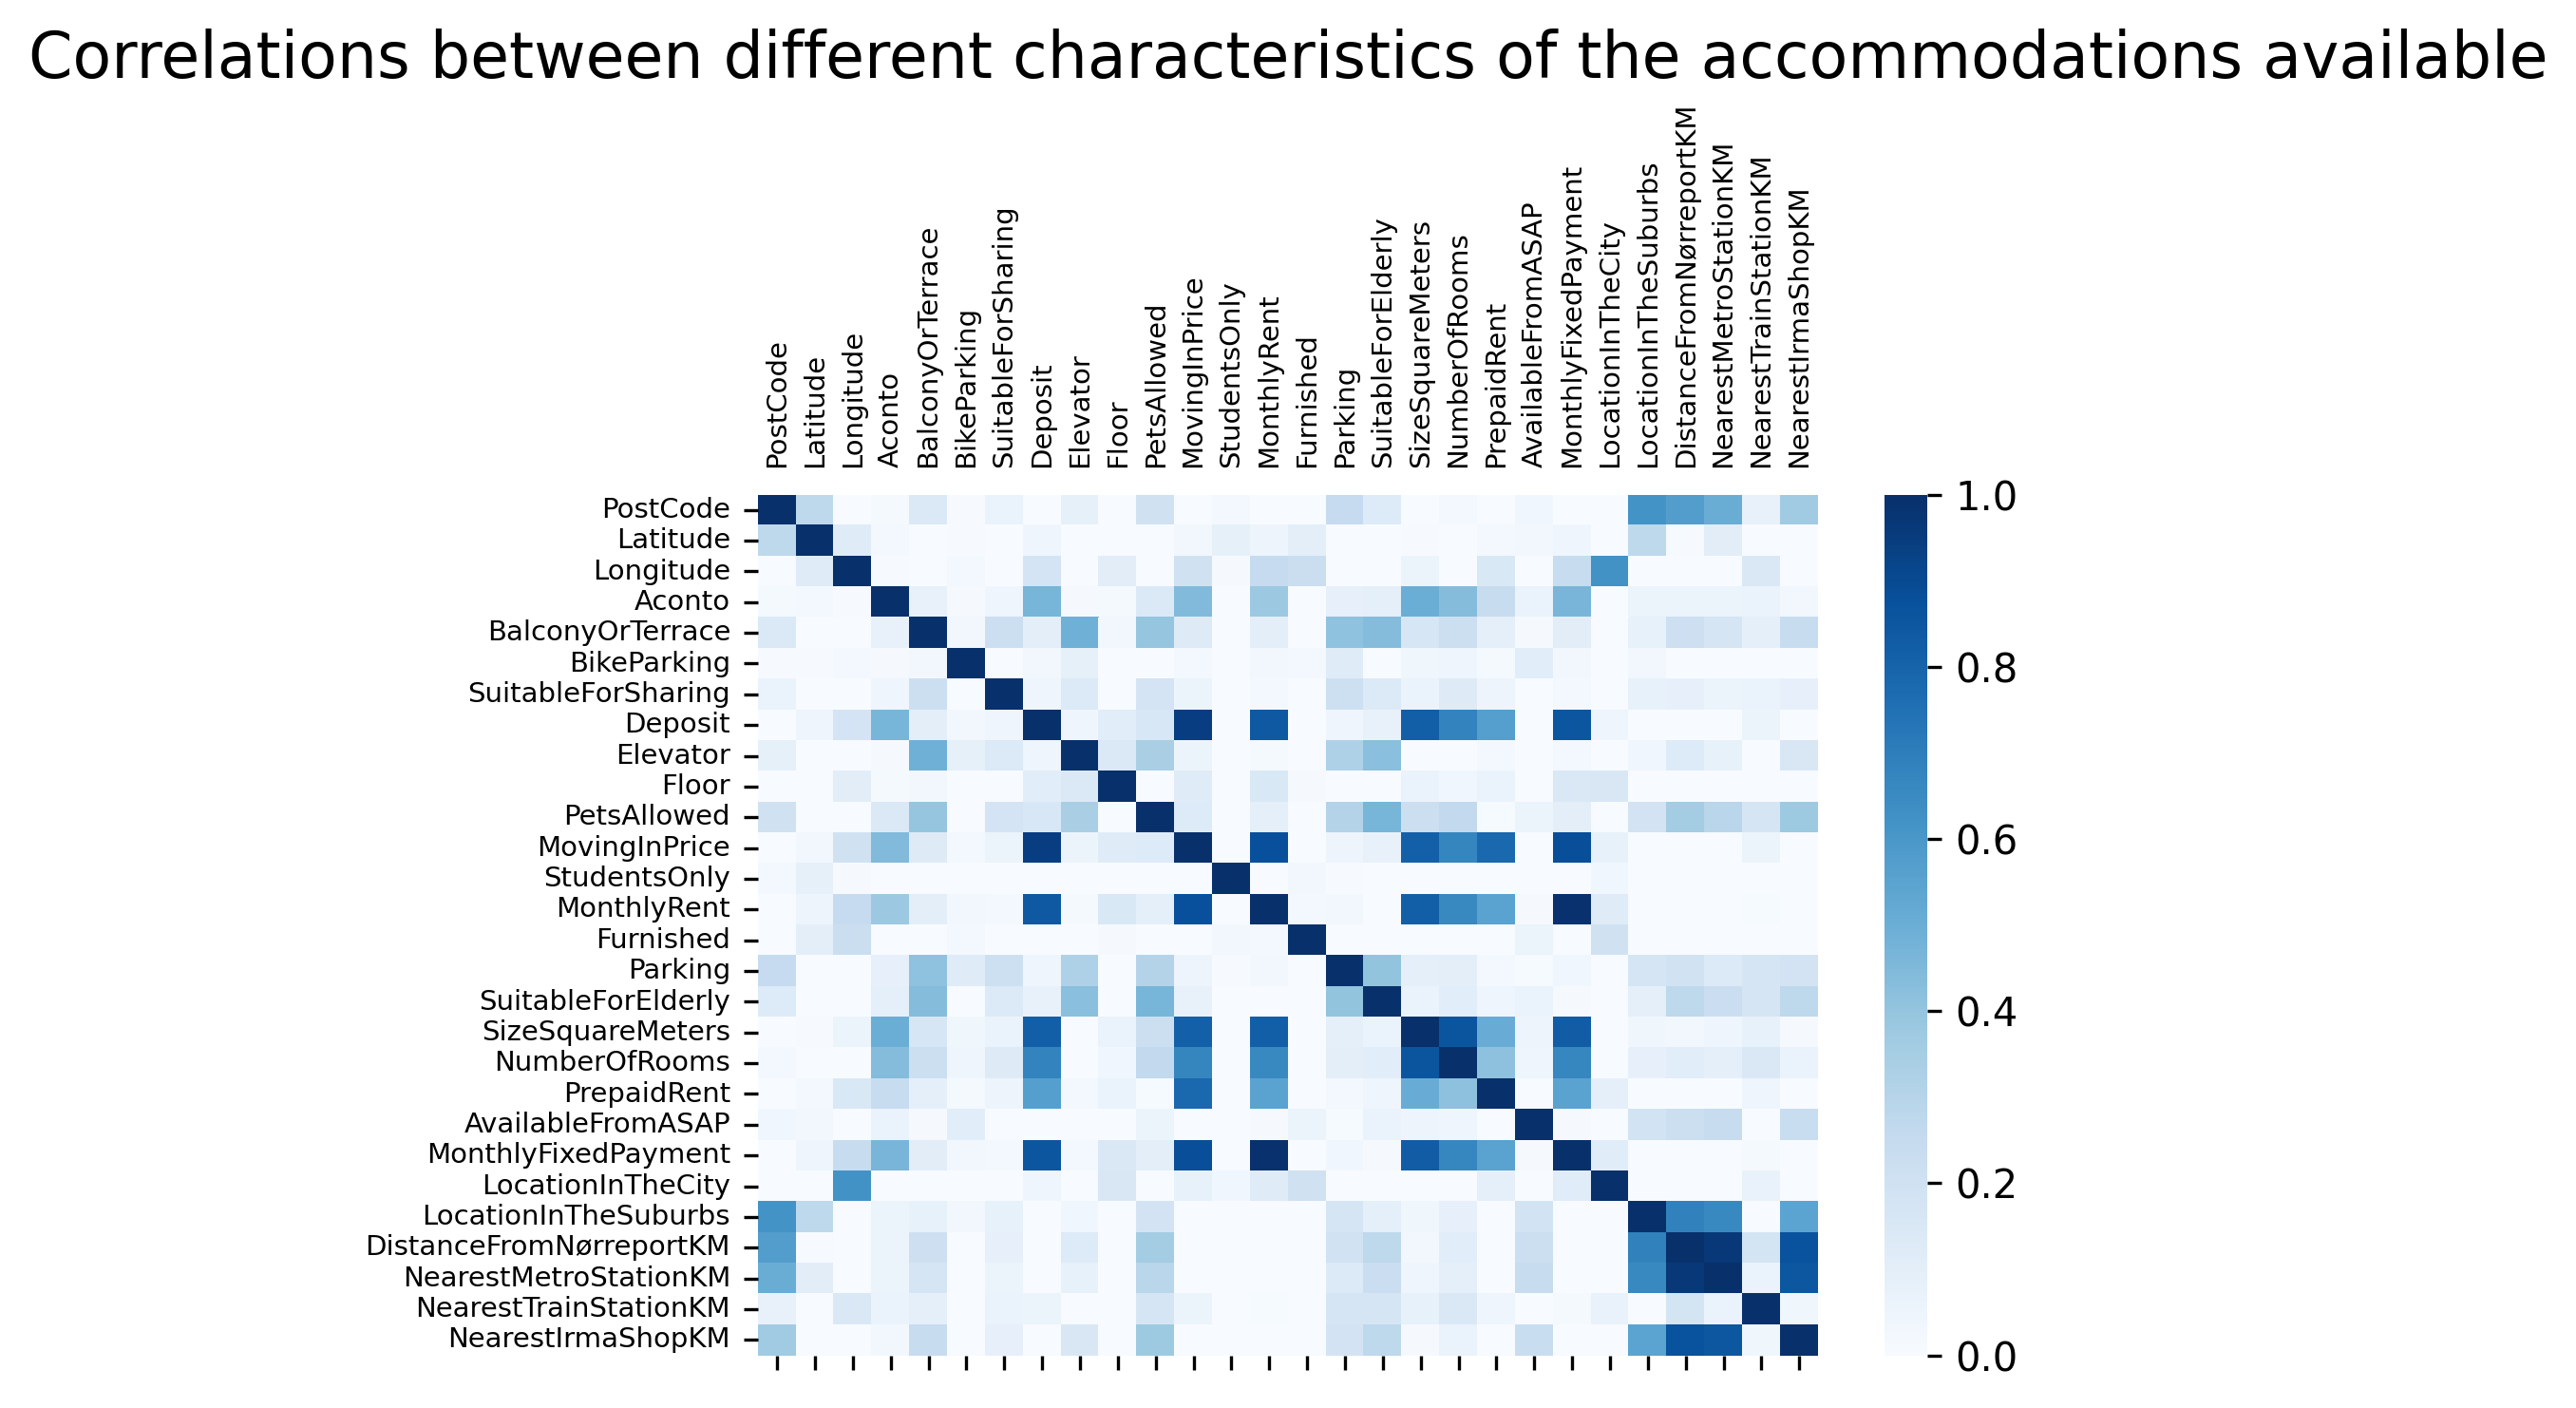

In [ ]:
# Plotting the correlations on a heatmap
sns.heatmap(Correlations, vmin = 0, vmax = 1, cmap = "Blues", xticklabels = True, yticklabels = True)
plt.title("Correlations between different characteristics of the accommodations available", fontsize = 16)
plt.tick_params(axis = "x", labelbottom = False, labeltop = True)
plt.xticks(rotation = 90, fontsize = 7)
plt.yticks(fontsize = 7)
plt.show()

### Variance inflation factor (VIF)

Below, we explore the variance inflation factor (VIF) for those variables which we are considering to include in our regression model(s). Generally, the VIF should be lower than 10 to ensure that multicollinearity will not pose an issue (though there are different opinions on the subject).

The table below shows that we have quite a few variables with a VIF that is way too high, including the GPS coordinates, the two metrics for size (number of square meteres and number of rooms) as well as for how long the landlord has been registered on BoligPortal. This suggest that we should avoid including all of these variable in the same model if we'd like to avoid issues related to multicollinearity:

In [ ]:
%%capture
# Producing a temporary dataset
DataForVIF = DataForAnalysis.copy()
DataForVIF.dropna(inplace = True)

# Variables need to be of the float64 dtype for the VIF test to work
# so we drop all variables that come in non-conforming data types (e.g. dates)
for col in DataForVIF.columns:
  if DataForVIF[col].dtype != "float64":
    DataForVIF.drop(columns = [col], inplace = True)

# Removing the "MonthlyFixedPayment" and other similar variables as they are
# perfectly correlated with the "Aconto" or "MonthlyRent" variables
# (keeping them in the dataframe will generate VIF = Infinity)
ColsToRemove = ["MonthlyFixedPayment", "Deposit", "PrepaidRent", "MonthlyRent", \
                "MovingInPrice", "LocationInTheSuburbs"]
DataForVIF.drop(columns = ColsToRemove, inplace = True)

# Generating a table with VIF
VIF = pd.DataFrame()
VIF["Variable"] = DataForVIF.columns
VIF["VIF Factor"] = [variance_inflation_factor(DataForVIF.values, i) for i in range(DataForVIF.shape[1])]
VIF.sort_values("VIF Factor", ascending = False, inplace = True)
VIF.reset_index(inplace = True, drop = True)
VIF["VIF Factor"] = np.round(VIF["VIF Factor"], 2)

In [ ]:
VIF

,Variable,VIF Factor
0,Latitude,268252.24
1,Longitude,266944.53
2,PostCode,115.89
3,DistanceFromNørreportKM,108.31
4,NearestMetroStationKM,27.82
5,SizeSquareMeters,22.83
6,NumberOfRooms,21.72
7,LocationInTheCity,16.31
8,NearestTrainStationKM,13.70
9,NearestIrmaShopKM,8.36


Below, we calculate the VIF once again, this time also dropping the following variables: `Latitude`, `Longitude` and `NumberOfRooms`. As we can see, this has improved the values of the VIF for the remaining variables quite a lot, even if `SizeSquareMeters` and `LandlordSinceXDays` are still a bit above the desired treshold of about 10:

In [ ]:
%%capture
# Producing a temporary dataset
DataForVIF = DataForAnalysis.copy()
DataForVIF.dropna(inplace = True)

# Variables need to be of the float64 dtype for the VIF test to work
# so we drop all variables that come in non-conforming data types (e.g. dates)
for col in DataForVIF.columns:
  if DataForVIF[col].dtype != "float64":
    DataForVIF.drop(columns = [col], inplace = True)

# Removing the "MonthlyFixedPayment" and other similar variables as they are
# perfectly correlated with the "Aconto" or "MonthlyRent" variables
# (keeping them in the dataframe will generate VIF = Infinity)
ColsToRemove = ["MonthlyFixedPayment", "Deposit", "PrepaidRent", "MonthlyRent", \
                "MovingInPrice", "LocationInTheSuburbs", \
                "Latitude", "Longitude", "NumberOfRooms", "DistanceFromNørreportKM"]
DataForVIF.drop(columns = ColsToRemove, inplace = True)

try:
  DataForVIF.drop(columns = ["LatitudeL1", "LongitudeL1"], inplace = True)
except:
  pass

# Generating a table with VIF
VIF = pd.DataFrame()
VIF["Variable"] = DataForVIF.columns
VIF["VIF Factor"] = [variance_inflation_factor(DataForVIF.values, i) for i in range(DataForVIF.shape[1])]
VIF.sort_values("VIF Factor", ascending = False, inplace = True)
VIF.reset_index(inplace = True, drop = True)
VIF["VIF Factor"] = np.round(VIF["VIF Factor"], 2)

In [ ]:
VIF

,Variable,VIF Factor
0,PostCode,16.89
1,SizeSquareMeters,8.90
2,LocationInTheCity,8.32
3,NearestMetroStationKM,7.64
4,Aconto,6.91
5,NearestIrmaShopKM,6.26
6,BalconyOrTerrace,5.27
7,Elevator,5.07
8,Parking,3.89
9,SuitableForElderly,3.55


## Hypothesis-based statistical analysis

In here, we define a series of hypotheses to be tested using regression models and/or t-tests or ANOVA. These hypotheses are largely inspired by the observations we made in our exploratory analysis.

### Definition of hypotheses

**Related to rent in absolute terms:**

* **H1**: Monthly rent is higher for accommodations with a bigger size measured by either square meters or number of rooms.

**Related to rent in relative terms (per sqm):**

* **H2**: Monthly rent per square meter is decreasing as the size of the accommodation increases so that e.g. bigger apartments are cheaper per sqm than smaller ones.
* **H3**: Monthly rent per square meter is higher in the city than it is in the suburbs.
* **H4**: Monthly rent per square meter is decreasing as we get further away from Copenhagen's city center (here defined as "Nørreport").
* **H5**: Monthly rent per square meter is decreasing as we get further away from the nearest metro and/or S-train station.
* **H6**: Monthly rent per square meter is higher the closer we are to an Irma supermarket.
* **H7**: Monthly rent per square meter is lower in locations where more accommodations are available for rent.
* **H8**: Monthly rent per square meter is higher in accommodations where keeping pets is allowed.
* **H9**: Monthly rent per square meter is higher in accommodations where parking is available.
* **H10**: Monthly rent per square meter is cheaper for accommodations which are available for longer-term rent.
* **H11**: Monthly rent per square meter is cheaper for accommodations with a lower energy efficiency rating.
* **H12**: Monthly rent per square meter is significantly different for accommodaitons of different types (e.g. single rooms vs. complete accommodations).

### Testing of individual hypotheses one at a time

#### H1: Higher monthly rent for larger accommodations

**Hypothesis**: Monthly rent is higher for accommodations with a bigger size measured by either square meters or number of rooms.

**Outcome (proved)**:
1. We discover a statistically significant relationship between `MonthlyRent` and `SizeSquareMeters`, with each additional square meter being associated with an increase in monthly rent of 140 kr. on average (adj. R²=67%).
2. Similarly, we discover a statistically significant relationship between `MonthlyRent` and `NumberOfRooms`, with each additional room being associated with an increase in monthly rent of 3,863 kr. on average (though number of rooms is able to explain less of the variation in rent, wtih an adj. R² = 43%).
3. When introducing both `SizeSquareMeters` and `NumberOfRooms`, we discover only a minor change in the effect of size in square meters on monthly rent (from 140 kr. to 163 kr.), whereas the effect of number of rooms actually turns out to be negative (-943 kr. per room). This is likely the result of the two predictor variables being correlated to a certain extent, however, it is also another confirmation of the fact that by choosing a larger accommodation, you can get a lower price per room.
4. A slight increase in skedasticity can be observed in the actual vs. residuals plots whenever `SizeSquareMeters` is used as a predictor variable, which suggests there might be some small issues with compliance with the Gauss-Markov assumptions for regression models. However, no flagrant violations of the assumptions are observed.

Testing OLS model with the following specification:
MonthlyRent ~ SizeSquareMeters 

                            OLS Regression Results                            
Dep. Variable:            MonthlyRent   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     921.3
Date:                Tue, 21 Feb 2023   Prob (F-statistic):          6.16e-177
Time:                        10:08:25   Log-Likelihood:                -29782.
No. Observations:                3034   AIC:                         5.957e+04
Df Residuals:                    3032   BIC:                         5.958e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

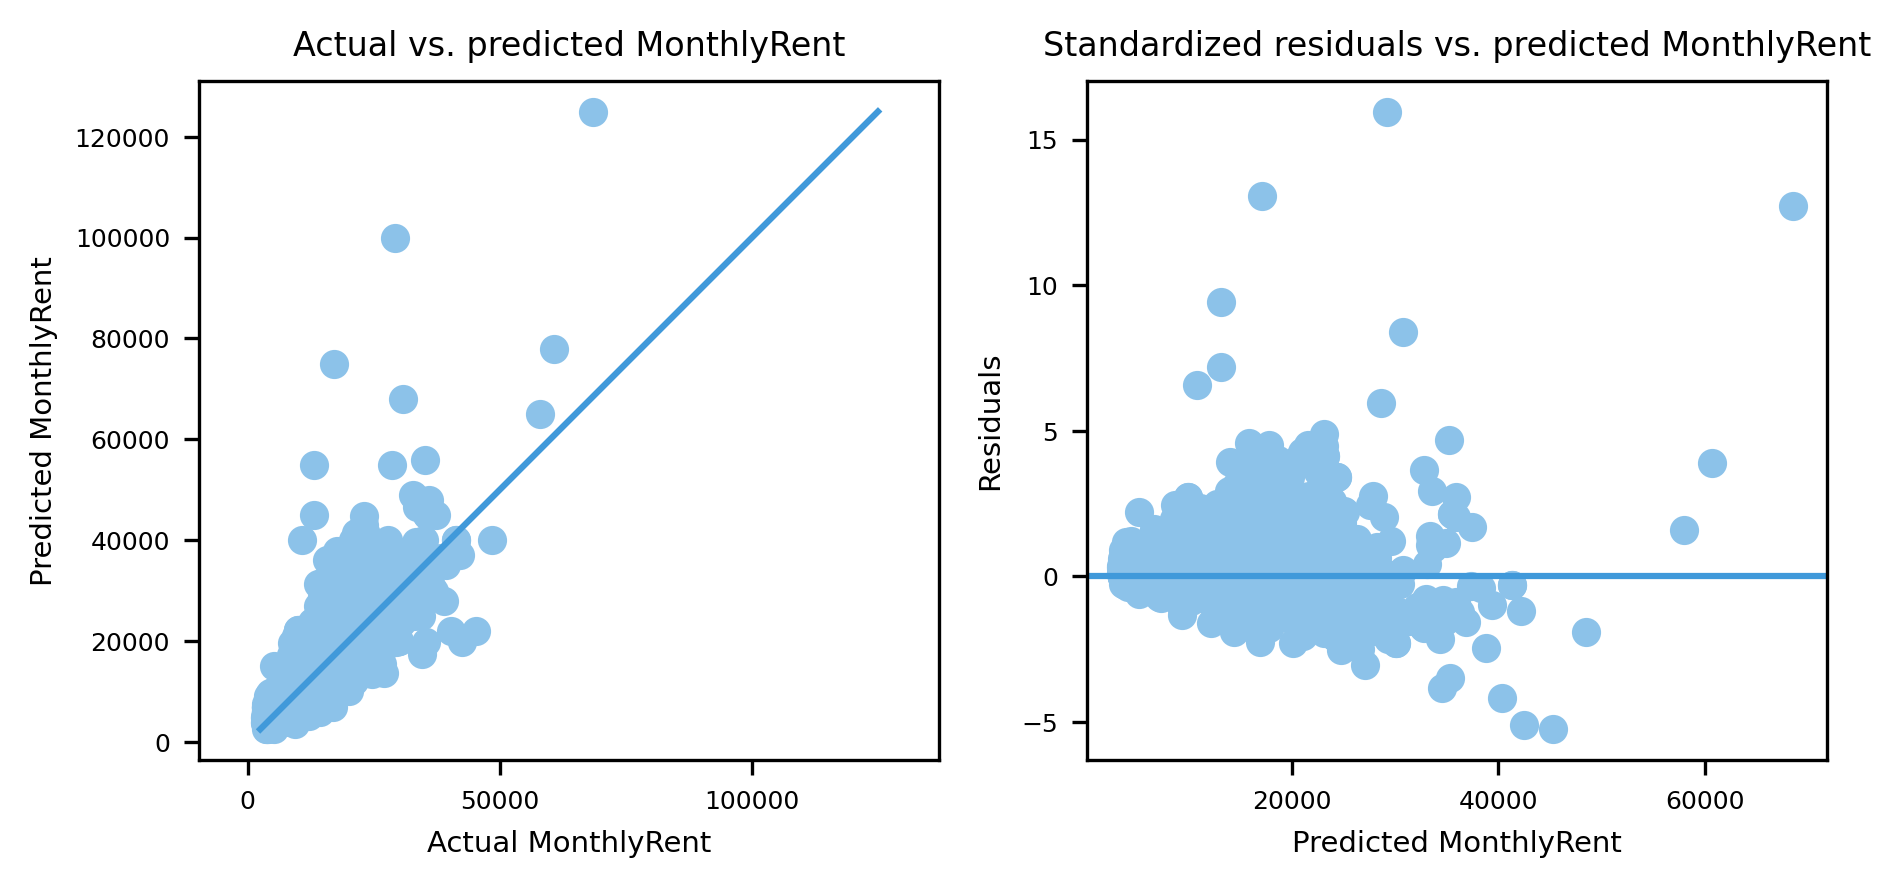

In [ ]:
# Model with size in square meters
FitRegressionModel("MonthlyRent ~ SizeSquareMeters", Accommodations)

Testing OLS model with the following specification:
MonthlyRent ~ NumberOfRooms 

                            OLS Regression Results                            
Dep. Variable:            MonthlyRent   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     686.1
Date:                Tue, 21 Feb 2023   Prob (F-statistic):          1.68e-136
Time:                        10:08:26   Log-Likelihood:                -30604.
No. Observations:                3034   AIC:                         6.121e+04
Df Residuals:                    3032   BIC:                         6.122e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

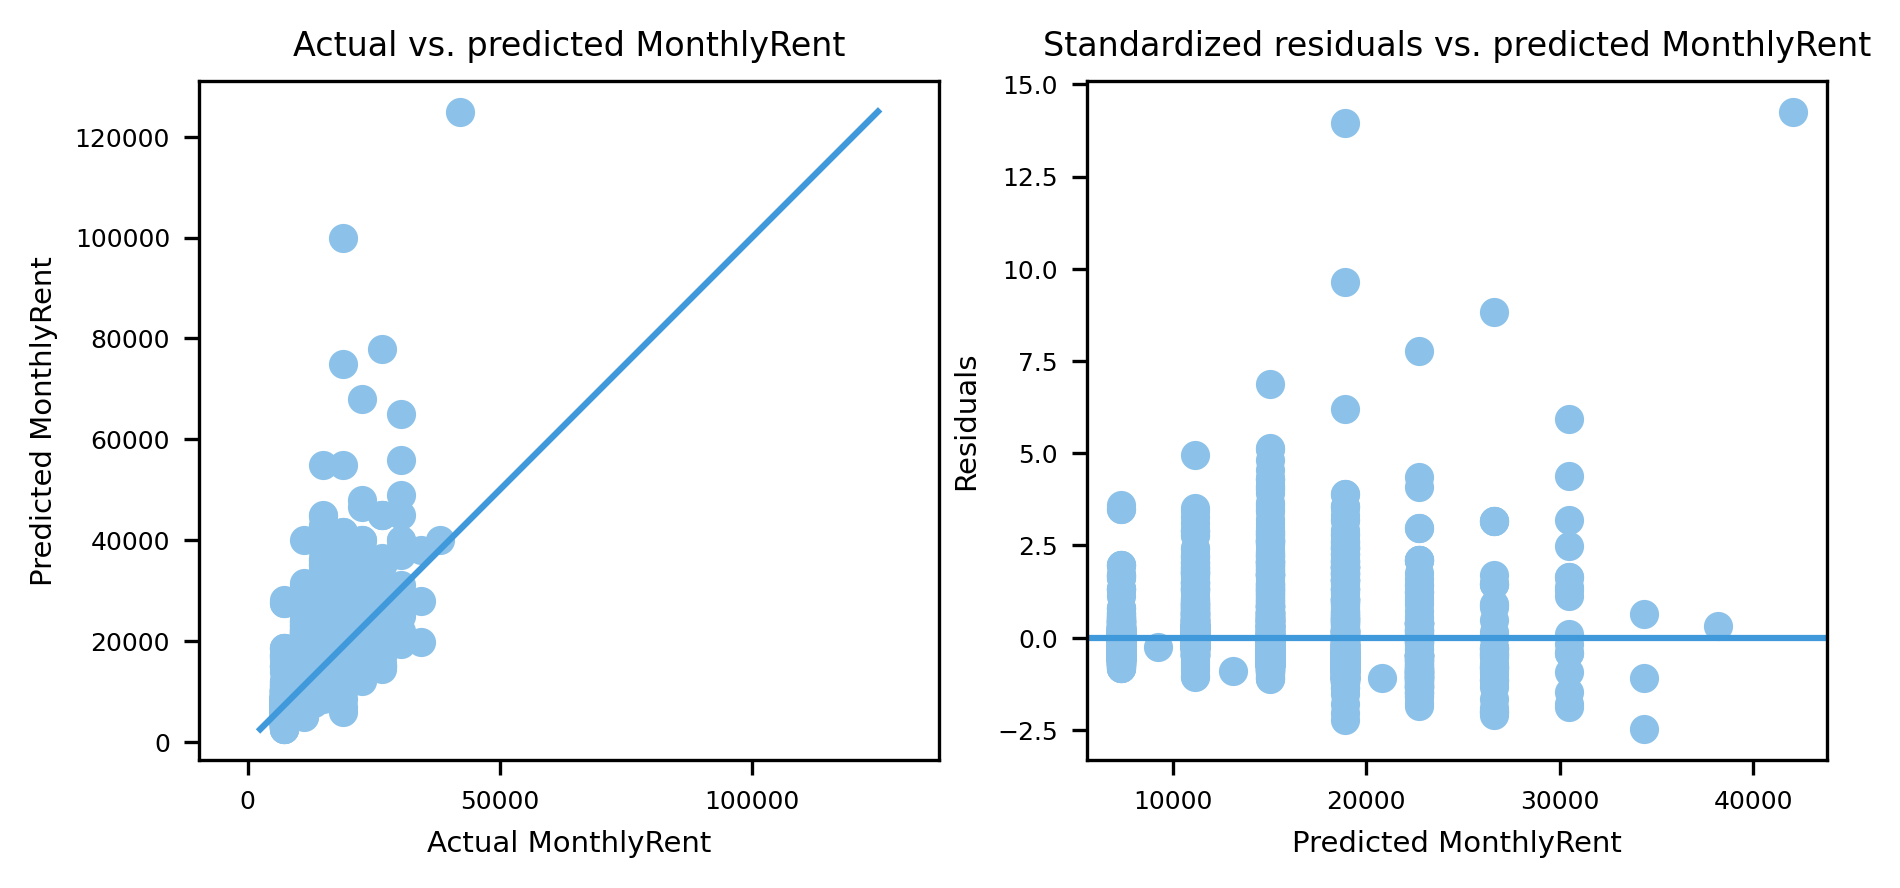

In [ ]:
# Model with number of rooms
FitRegressionModel("MonthlyRent ~ NumberOfRooms", Accommodations)

Testing OLS model with the following specification:
MonthlyRent ~ SizeSquareMeters + NumberOfRooms 

                            OLS Regression Results                            
Dep. Variable:            MonthlyRent   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     820.5
Date:                Tue, 21 Feb 2023   Prob (F-statistic):          1.63e-285
Time:                        10:08:27   Log-Likelihood:                -29750.
No. Observations:                3034   AIC:                         5.951e+04
Df Residuals:                    3031   BIC:                         5.952e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------

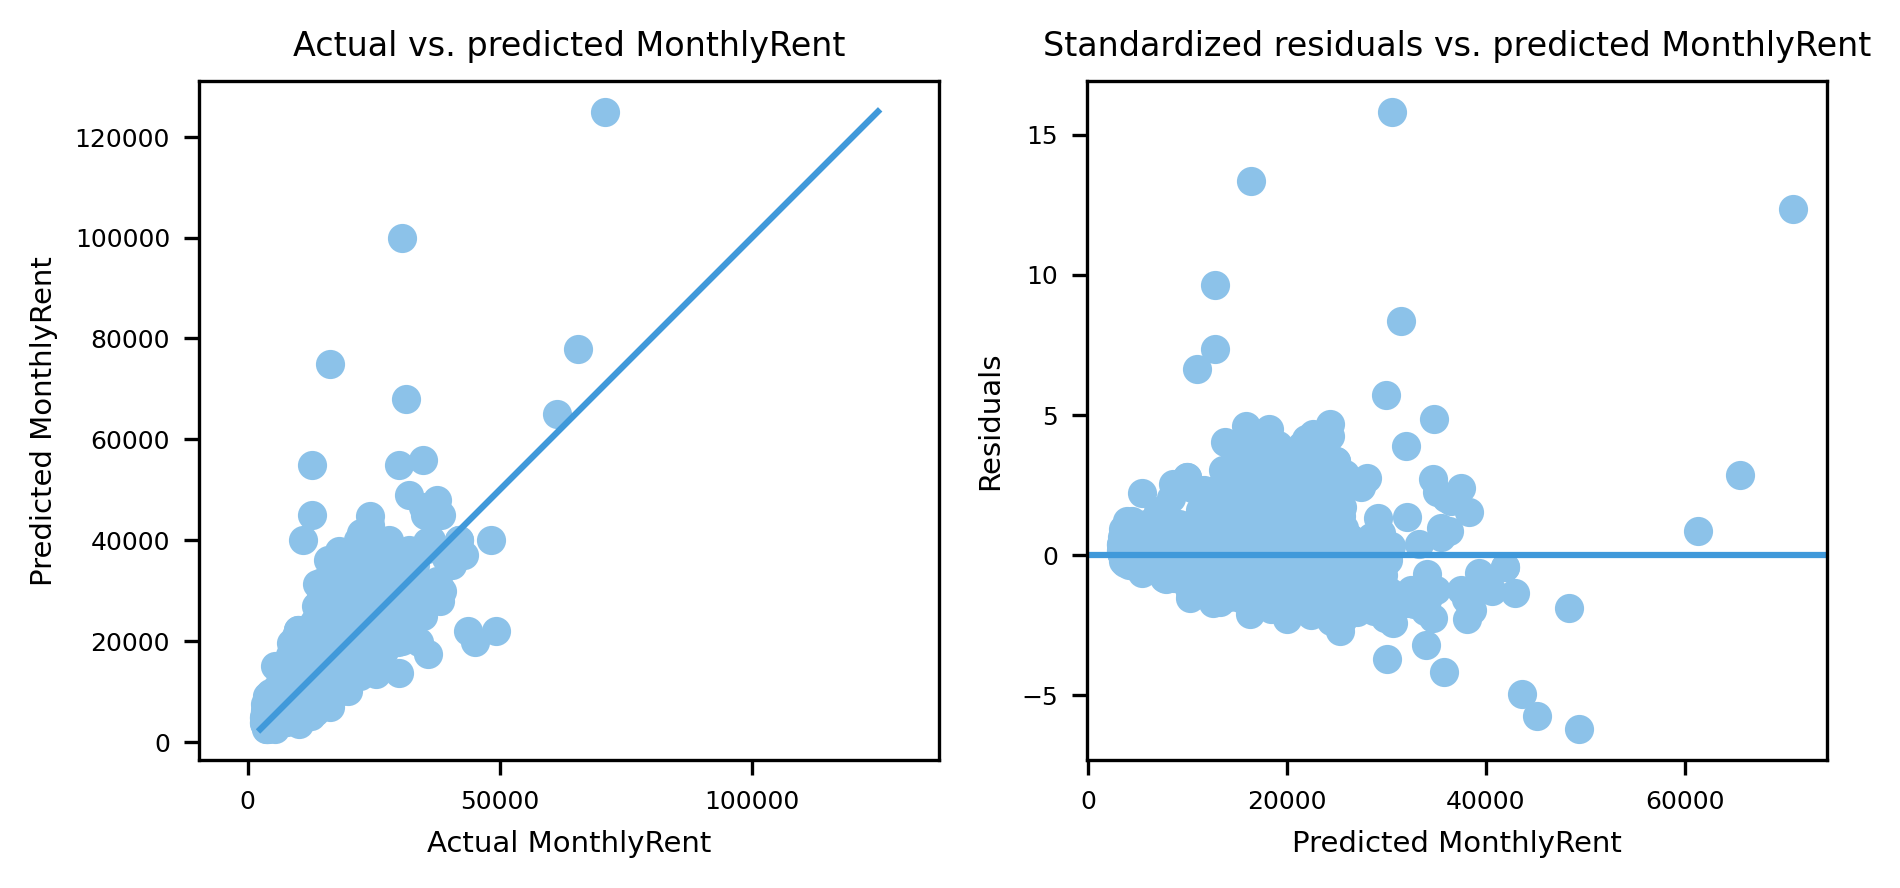

In [ ]:
# Model with size in square meters and number of rooms
FitRegressionModel("MonthlyRent ~ SizeSquareMeters + NumberOfRooms", Accommodations)

#### H2: Each additional square meter is cheaper than the previous

**Hypothesis**: Monthly rent per square meter is decreasing as the size of the accommodation increases so that e.g. bigger apartments are cheaper per sqm than smaller ones.

**Outcome (proved but with caution)**:
1. We discover a statistically significant relationship between `MonthlyRentBySqm` and `SizeSquareMeters`, with each additional square meter being associated with an decrease in the price per square meter of about 1.13 kr.
2. However, the explanatory power of the model is rather low (adj. R²=28%) and this is also obvious from the actual vs. predicted plot, where we can see that the model is not very good at predicting the price per square meter at higher price levels.
3. Furthermore, we see signs of heteroskedasticity in the predicted vs. residuals plot, suggesting likely violation of the Gauss-Markov assumptions, though both this and the model fit could be explained by the presence of outlier observations, whose removal might help improve the model.

Testing OLS model with the following specification:
MonthlyRentBySqM ~ SizeSquareMeters 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     311.3
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           2.17e-66
Time:                        10:08:28   Log-Likelihood:                -17701.
No. Observations:                3034   AIC:                         3.541e+04
Df Residuals:                    3032   BIC:                         3.542e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

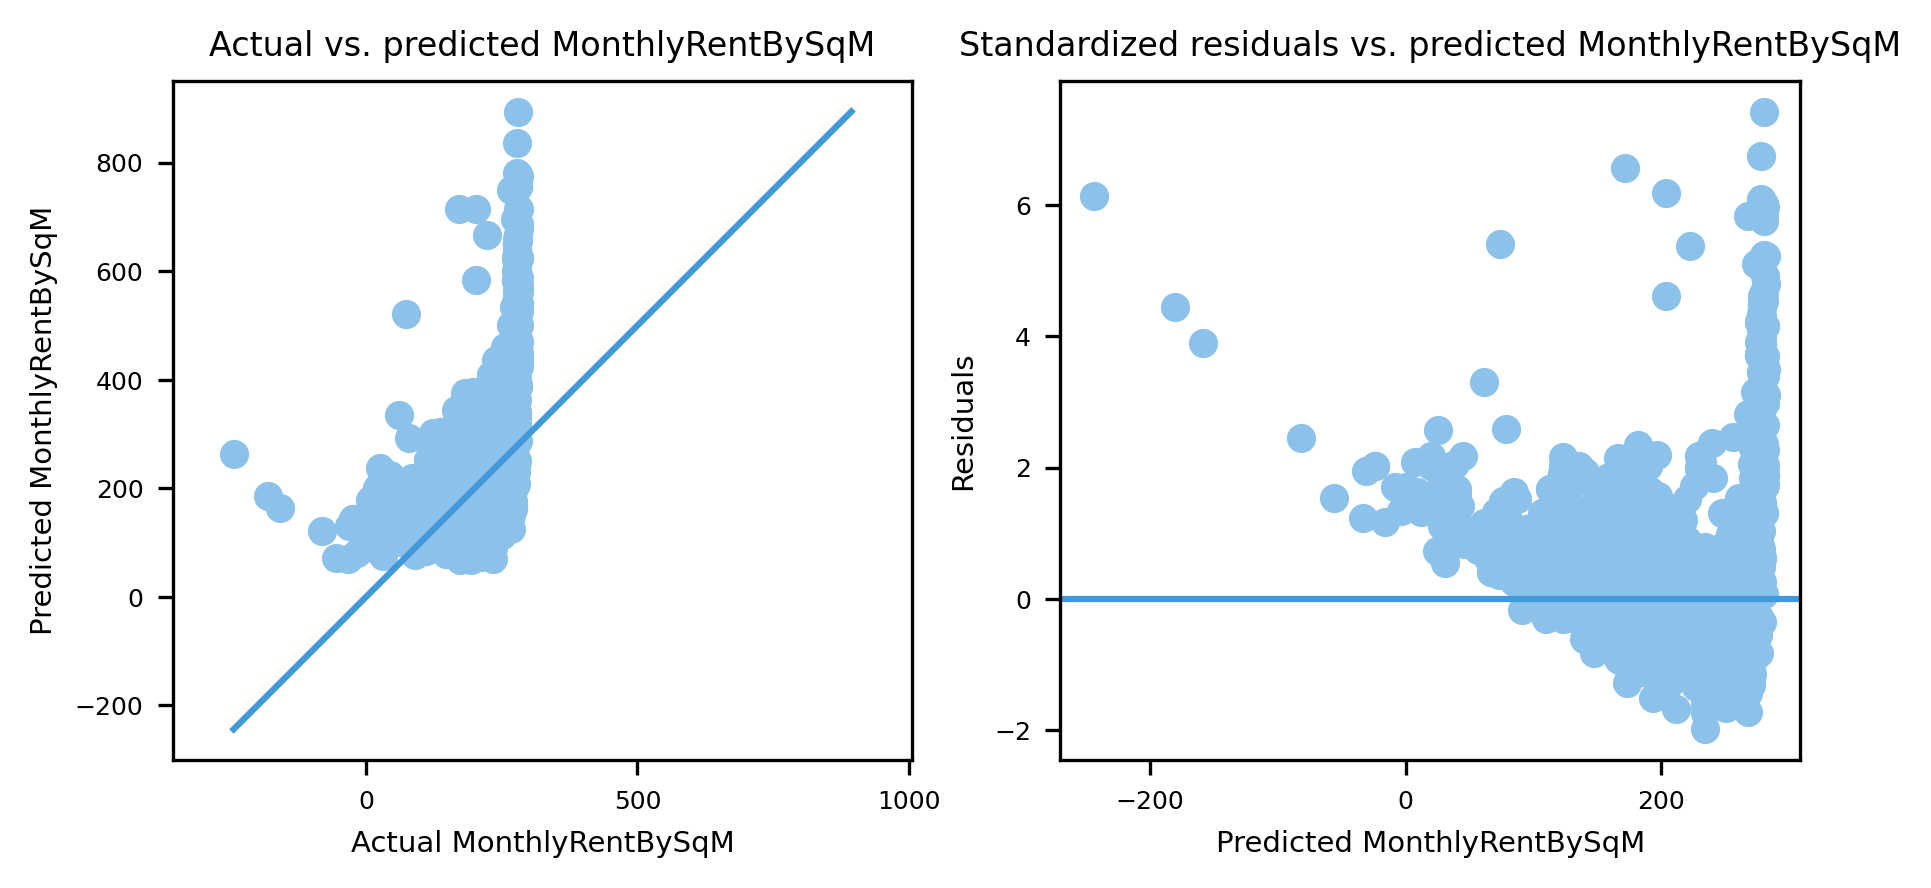

In [ ]:
FitRegressionModel("MonthlyRentBySqM ~ SizeSquareMeters", Accommodations)

#### H3: Square meters are cheaper in the suburbs

**Hypothesis**: Monthly rent per square meter is higher in the city than it is in the suburbs.

**Outcome (proved)**:
1. As we're testing a model where the only predictor is a binary variable (`LocationType`), we get a model with a relatively poor fit (adj. R²=7.4%) and exploring the usual plots is not very informative.
2. Nevertheless, we still unveal a statistically significant relationship between `MonthlyRentBySqm` and `LocationType`, with accommodations located in the suburbs expected to cost about 53 kr. less on average (per square meter).

Testing OLS model with the following specification:
MonthlyRentBySqM ~ LocationType 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     234.6
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           4.56e-51
Time:                        10:08:29   Log-Likelihood:                -18074.
No. Observations:                3034   AIC:                         3.615e+04
Df Residuals:                    3032   BIC:                         3.616e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

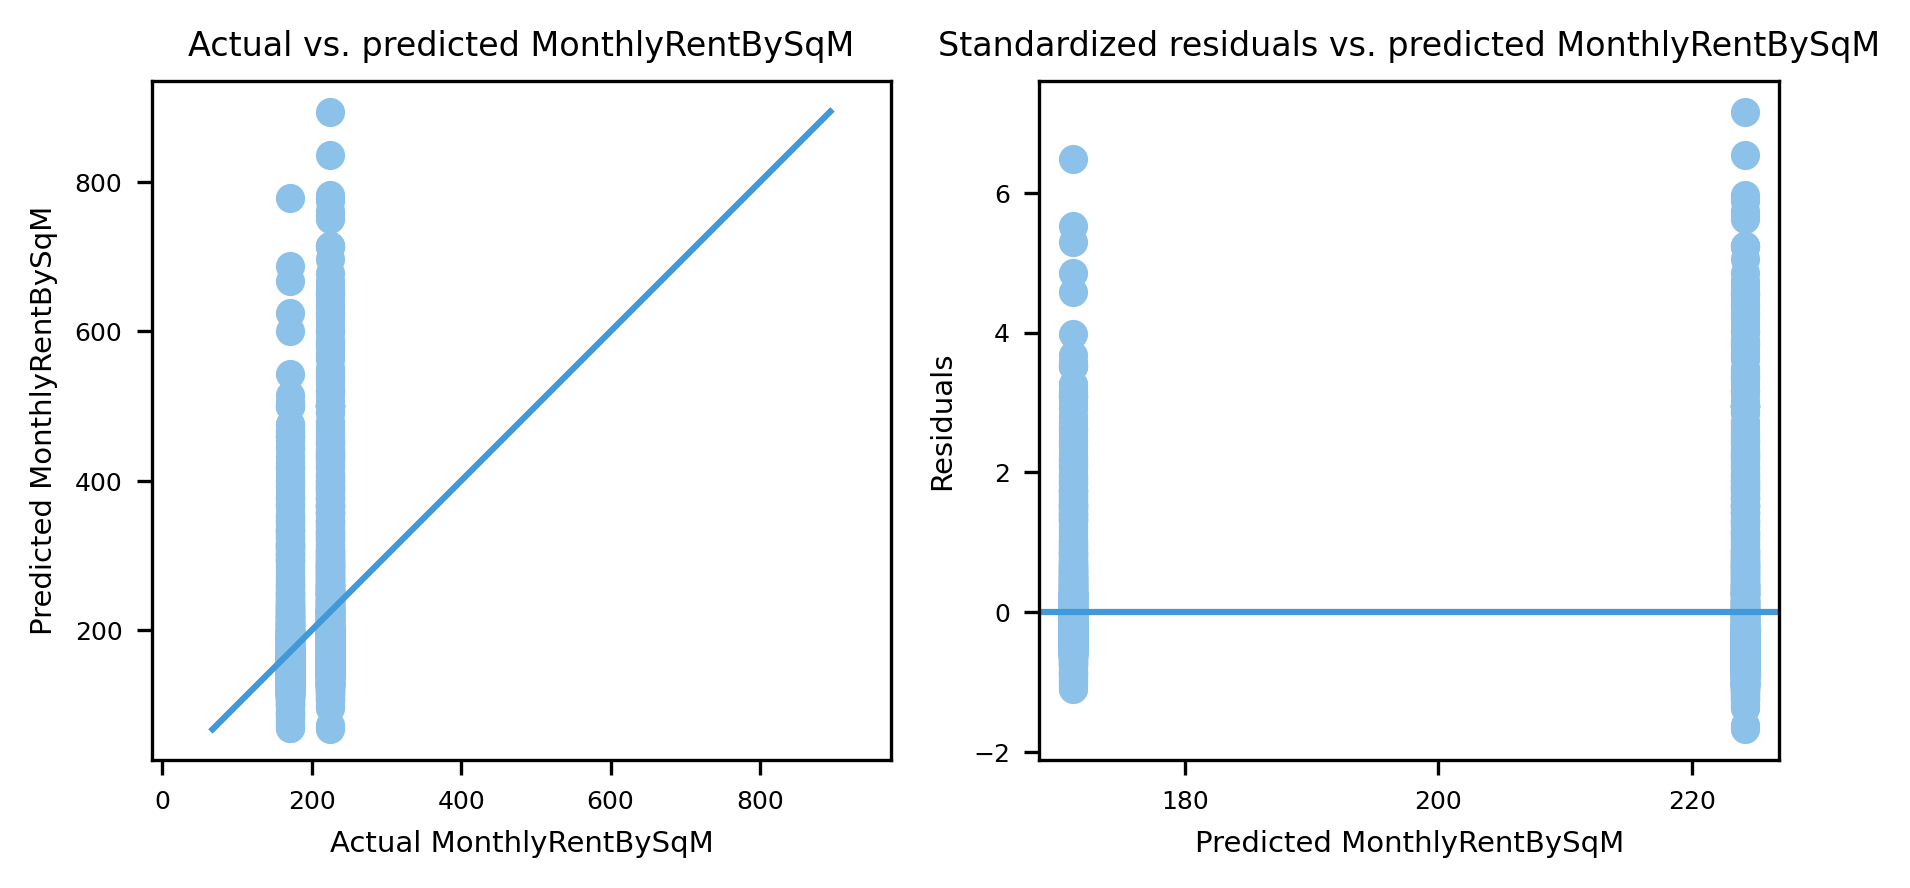

In [ ]:
FitRegressionModel("MonthlyRentBySqM ~ LocationType", Accommodations)

#### H4: Square meters are cheaper when farther away from Nørreport

**Hypothesis**: Monthly rent per square meter is decreasing as we get further away from Copenhagen's city center (here defined as "Nørreport").

**Outcome (proved but with caution)**:
1. First of all, we discover that there are clear signs of heteroskedasticity in the model's predictions and residuals, which means that not all of the Gauss-Markov assumptions can be met. This in turn means that we should take the conclusion in point 2 with a grain of salt.
2. Second, we discover the presence of a statistically significant relationship between `MonthlyRentBySqM` and `DistanceFroNørreport` such that for every KM we get farther away from Nørreport, the price per square meter drops by about 5.73 kr. However, it has to be noted that the model has a relatively poor fit (adj. R²=11%) and that its accuracy decreases as the rent price gets higher.

Testing OLS model with the following specification:
MonthlyRentBySqM ~ DistanceFromNørreportKM 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     529.8
Date:                Tue, 21 Feb 2023   Prob (F-statistic):          3.46e-108
Time:                        10:08:29   Log-Likelihood:                -18014.
No. Observations:                3034   AIC:                         3.603e+04
Df Residuals:                    3032   BIC:                         3.604e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------

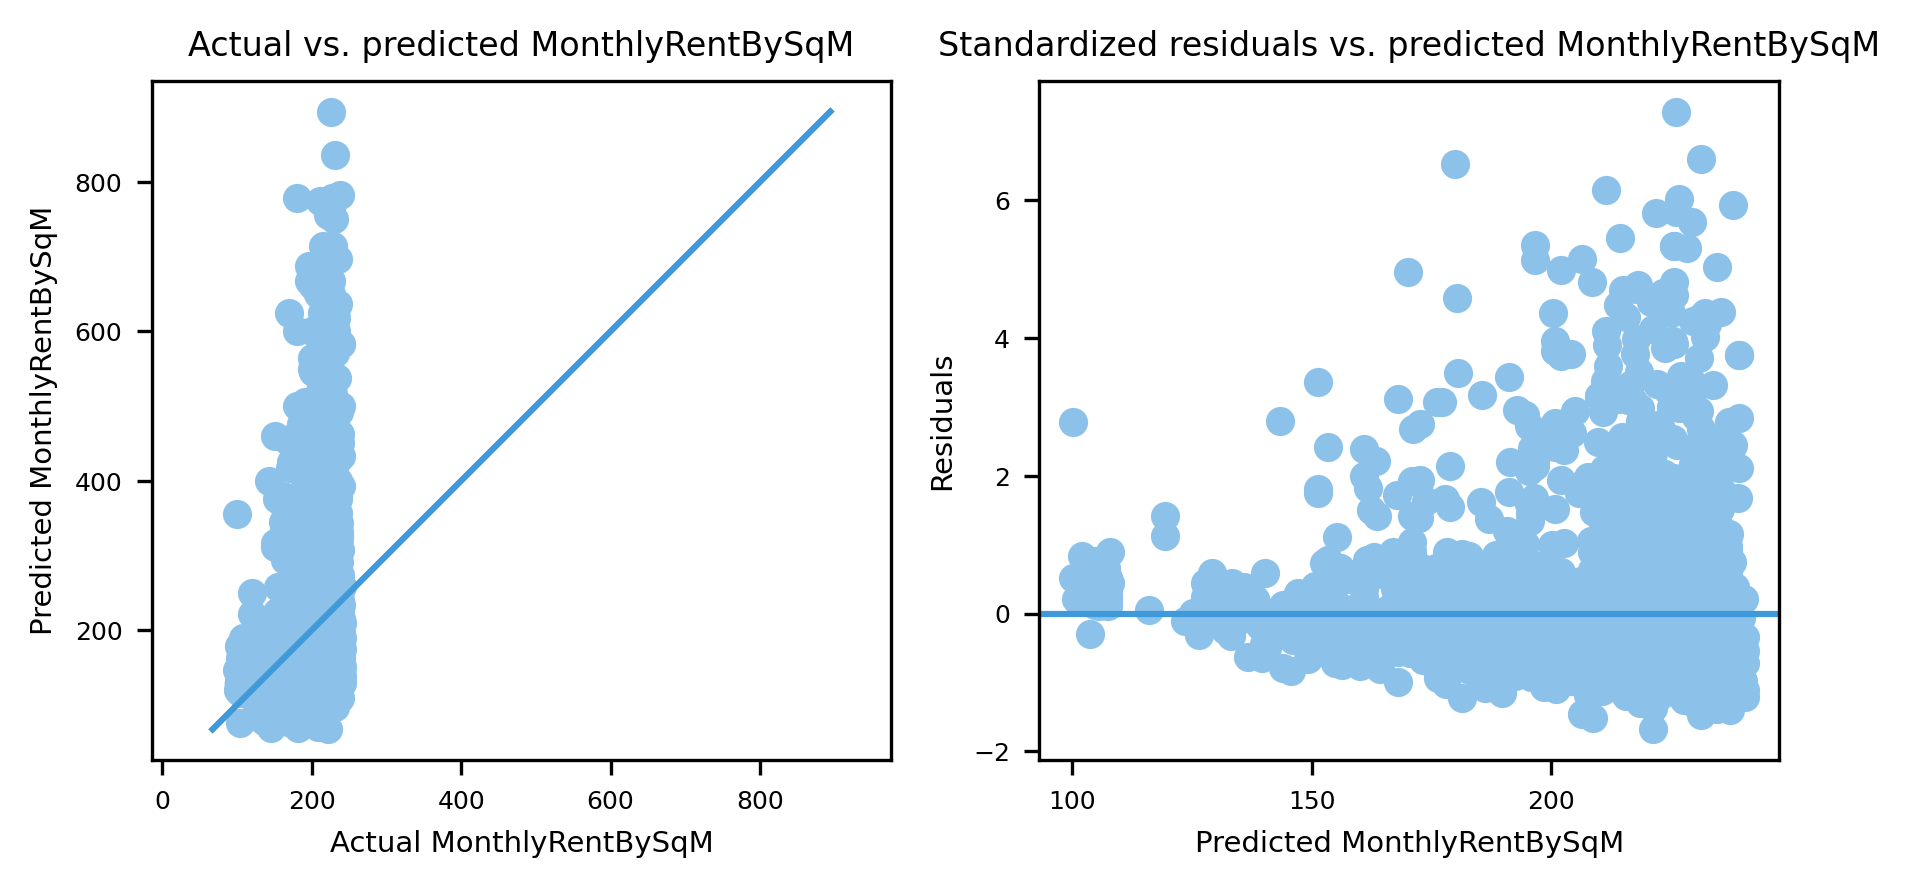

In [ ]:
FitRegressionModel("MonthlyRentBySqM ~ DistanceFromNørreportKM", Accommodations)

#### H5: It's more expensive to live closer to higher-quality public transit

**Hypothesis**: Monthly rent per square meter is decreasing as we get further away from the nearest metro and/or S-train station.

**Outcome (proved but with caution)**:
1. Whether we look at metro stations, S-train stations or both, this factor alone can only explain less than 10% of what's driving rent prices (max adj. R²=8.5%). Furthermore, we see clear signs of heteroskedasticity in all three models tested, suggesting the conclusion should be taken with a grain of salt due to likely problems with the Gauss-Markov assumptions.
2. Between metro and S-train, distance from nearest metro station seems to be a much better predictor of rent prices. For each kilometer you get closer to a metro station, you should expect to pay 5.79 kr. more on average (per square meter).

Testing OLS model with the following specification:
MonthlyRentBySqM ~ NearestMetroStationKM 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     482.6
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           2.18e-99
Time:                        10:08:30   Log-Likelihood:                -18056.
No. Observations:                3034   AIC:                         3.612e+04
Df Residuals:                    3032   BIC:                         3.613e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

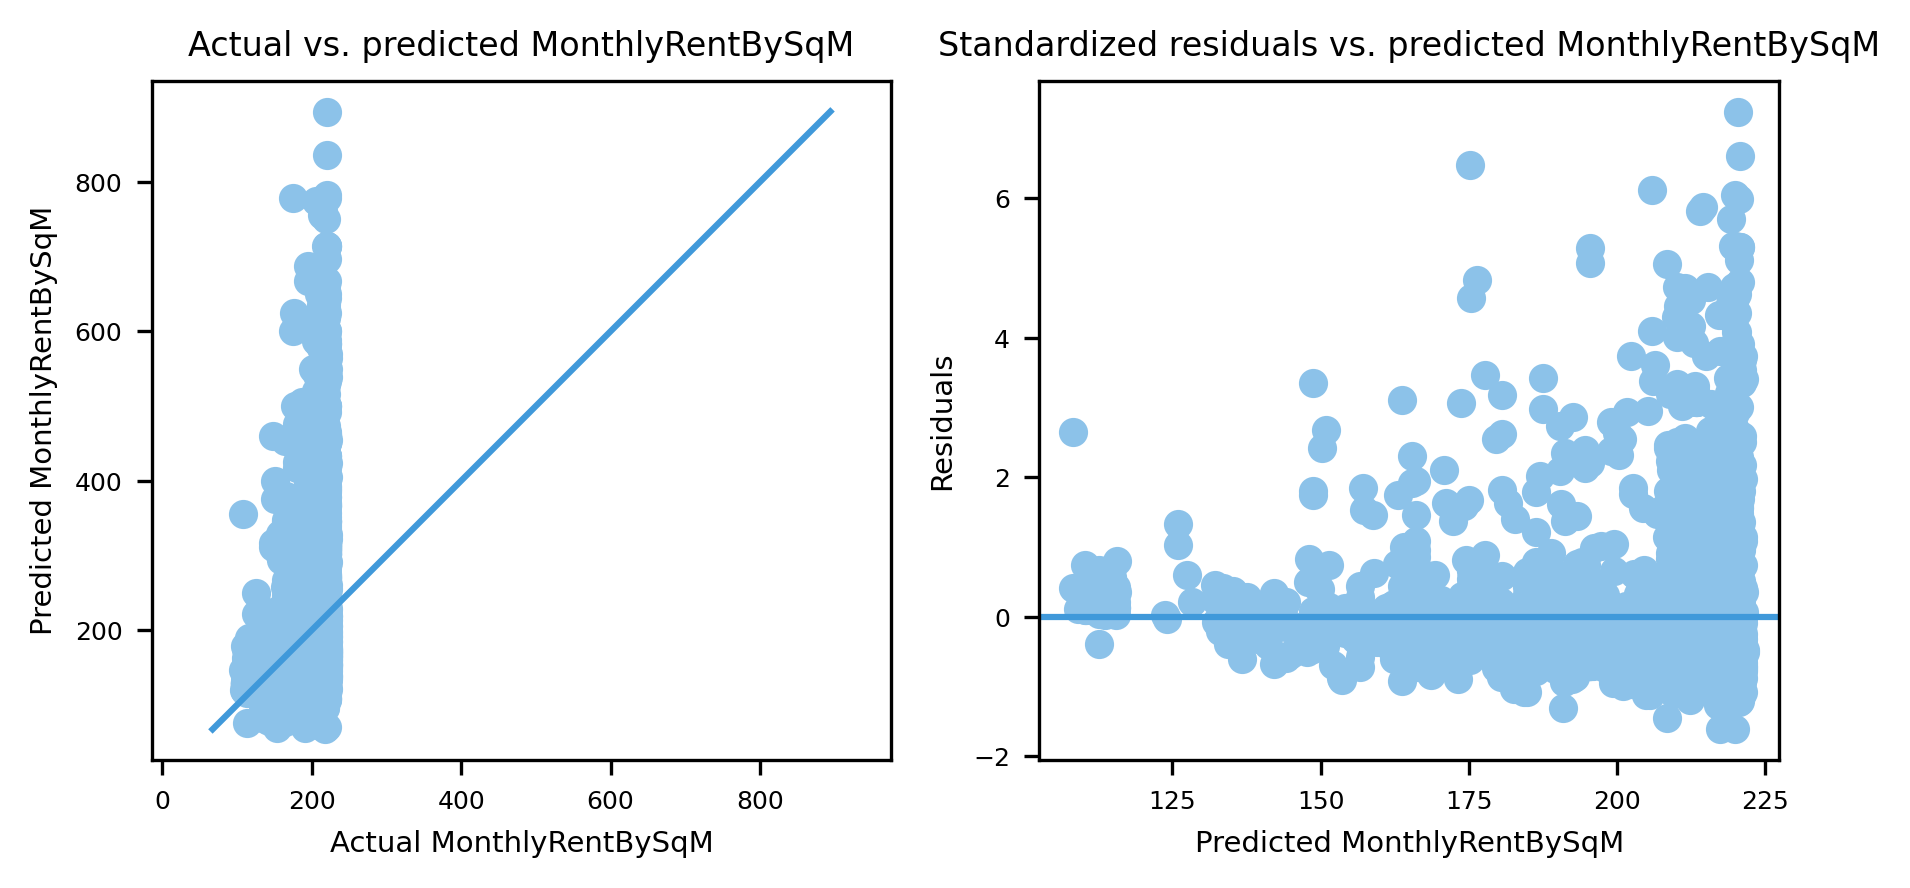

In [ ]:
# Model with distance from nearest metro station
FitRegressionModel("MonthlyRentBySqM ~ NearestMetroStationKM", Accommodations)

Testing OLS model with the following specification:
MonthlyRentBySqM ~ NearestTrainStationKM 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     33.11
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           9.56e-09
Time:                        10:08:31   Log-Likelihood:                -18178.
No. Observations:                3034   AIC:                         3.636e+04
Df Residuals:                    3032   BIC:                         3.637e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

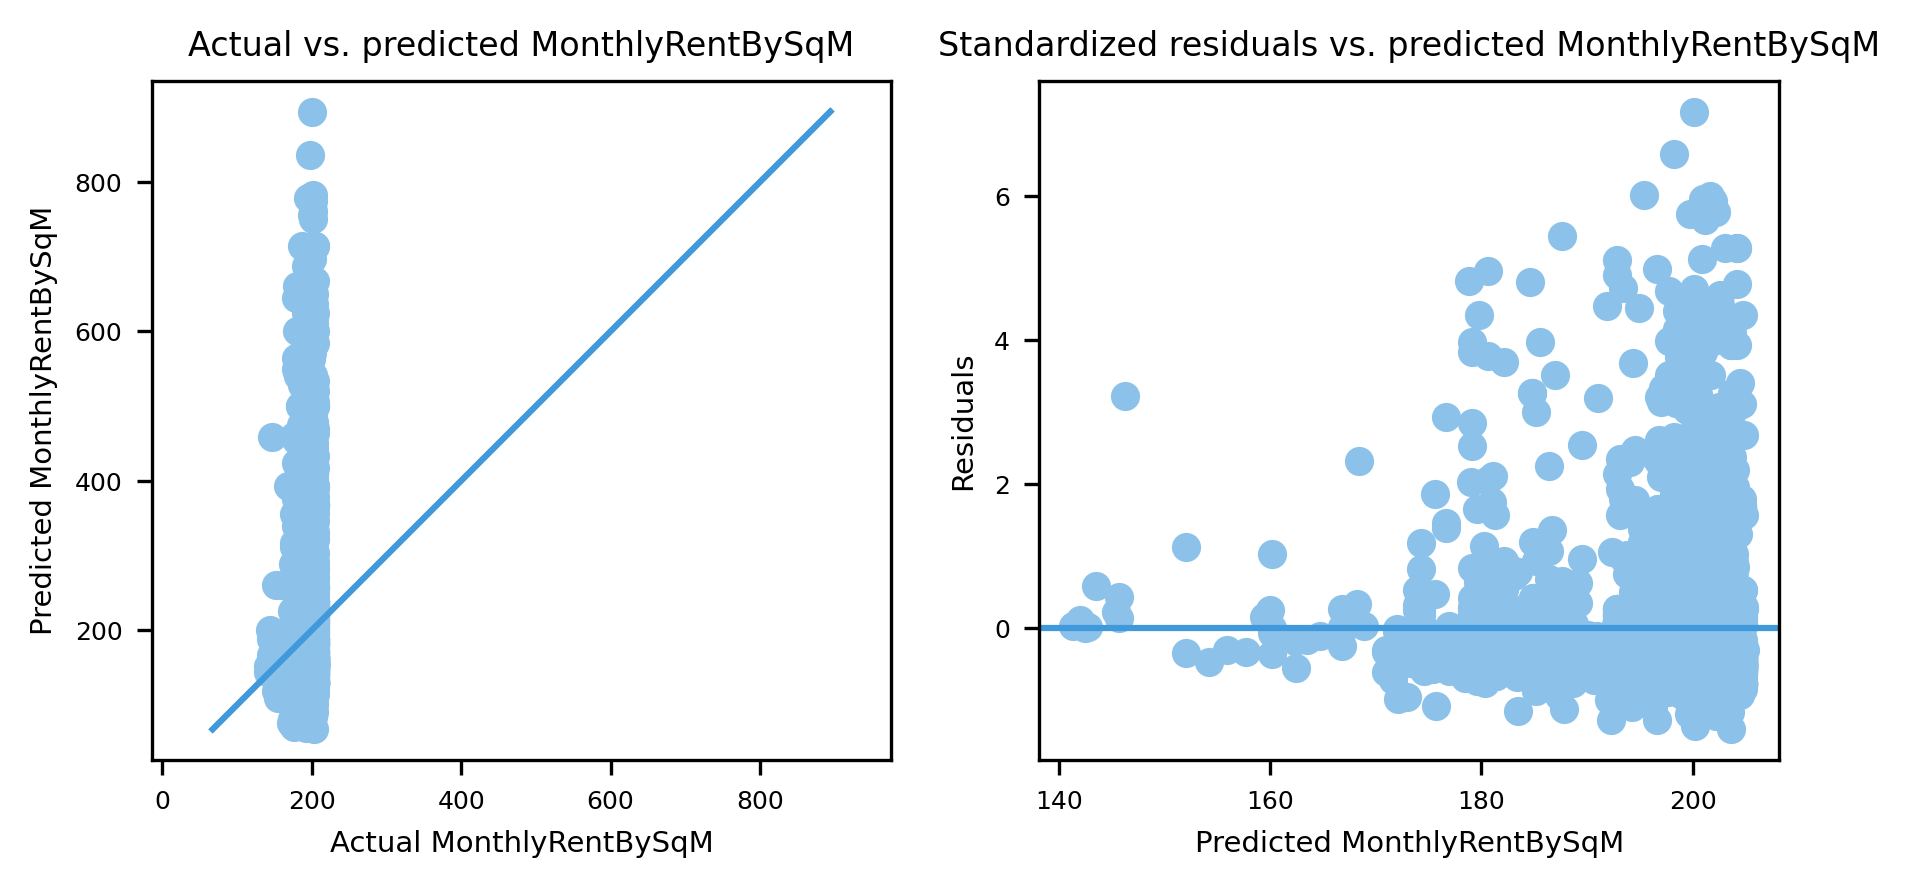

In [ ]:
# Model with distance from nearest S-train station
FitRegressionModel("MonthlyRentBySqM ~ NearestTrainStationKM", Accommodations)

Testing OLS model with the following specification:
MonthlyRentBySqM ~ NearestMetroStationKM + NearestTrainStationKM 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     234.6
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           1.90e-95
Time:                        10:08:32   Log-Likelihood:                -18047.
No. Observations:                3034   AIC:                         3.610e+04
Df Residuals:                    3031   BIC:                         3.612e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-

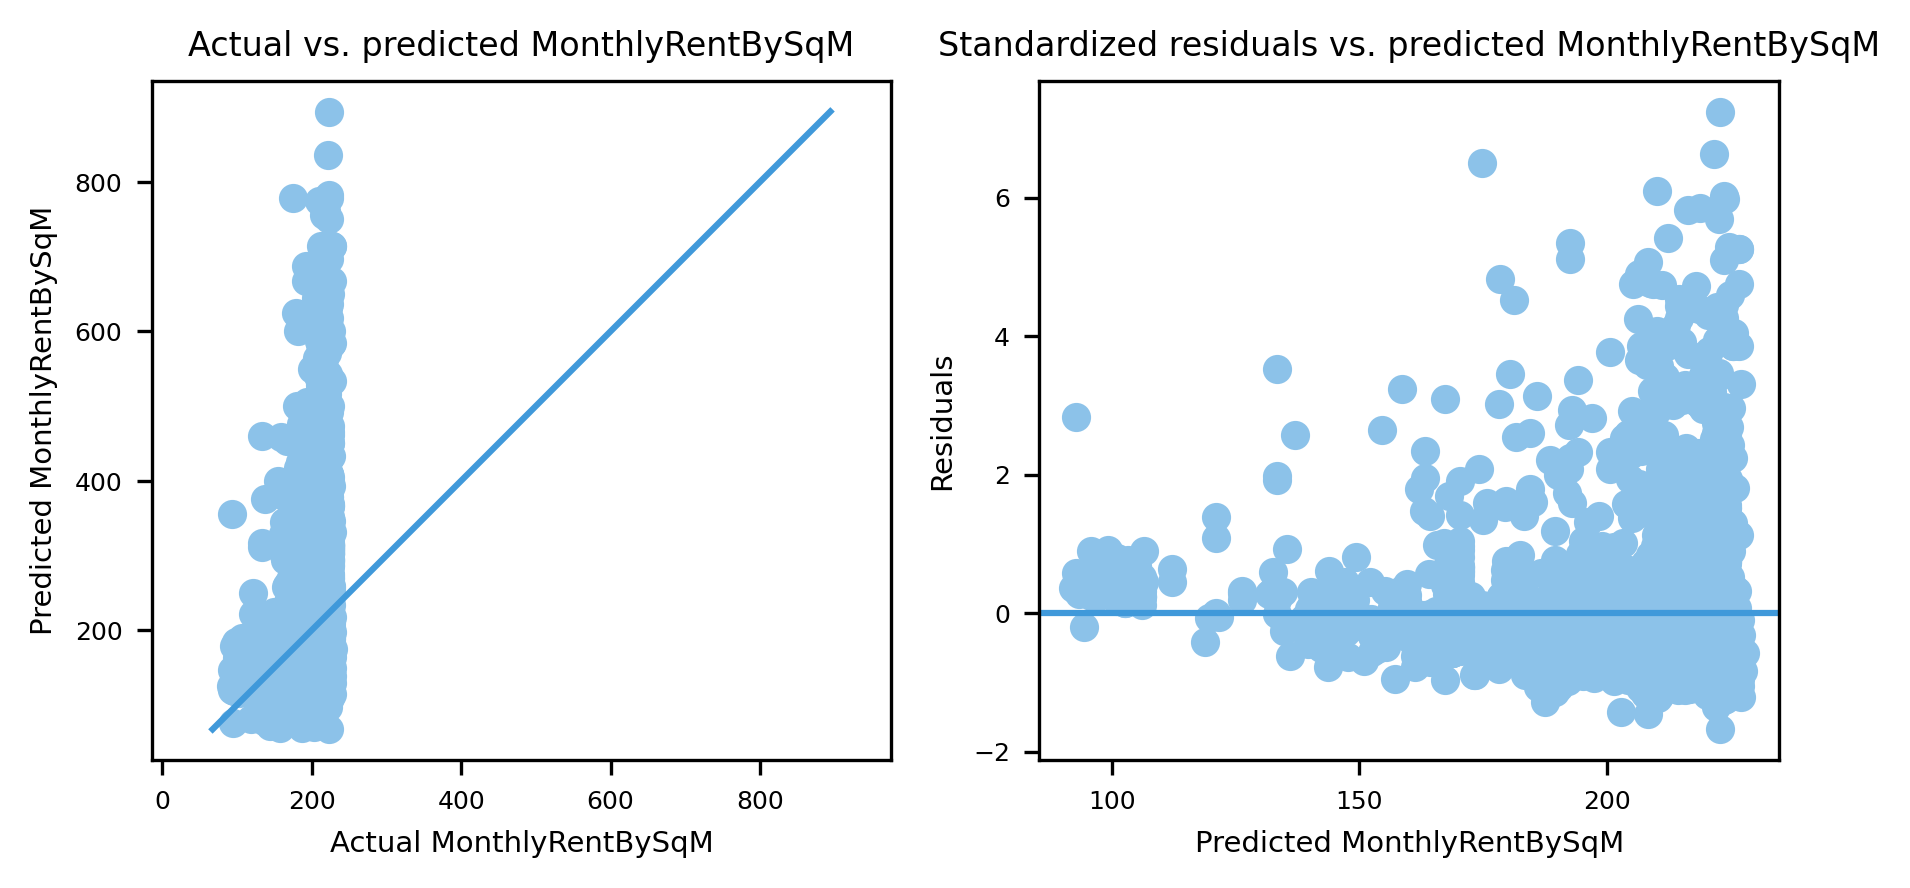

In [ ]:
# Model with distance from both nearest metro station and nearest S-train station
FitRegressionModel("MonthlyRentBySqM ~ NearestMetroStationKM + NearestTrainStationKM", Accommodations)

#### H6: Irma supermarkets are located in more expensive areas of town

**Hypothesis**: Monthly rent per square meter is higher the closer we are to an Irma supermarket.

**Outcome (rejected)**:

1. Contrary to our expectations, we discover that the presence of an Irma shop close to an accommodation is associated with a lower monthly rent. Speicifcally, for each KM you get closer to an Irma shop, you may expect a reduction in monthly rent per sqm of about 11.74 kr. on average.
2. That being said, the model does not have the best fit ever, with it being able to explain less than 10% of what drives monthly rent prices (adj. R²=9.6%). Curiously though (and even though the difference in R² is very minor), the model where we try to predict rent prices based on distance from the closest Irma shop seems to be able ever so slightly better at explaining rent prices than the model that contains the distance from both the nearest train and the nearest metro station.
3. Finally, we can also see that some issues with the Gauss-Markov assumption about homoskedasticity may be present, which may of course undermine the reliability of the parameter estimates.

Testing OLS model with the following specification:
MonthlyRentBySqM ~ NearestIrmaShopKM 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     673.5
Date:                Tue, 21 Feb 2023   Prob (F-statistic):          2.89e-134
Time:                        10:08:32   Log-Likelihood:                -18037.
No. Observations:                3034   AIC:                         3.608e+04
Df Residuals:                    3032   BIC:                         3.609e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

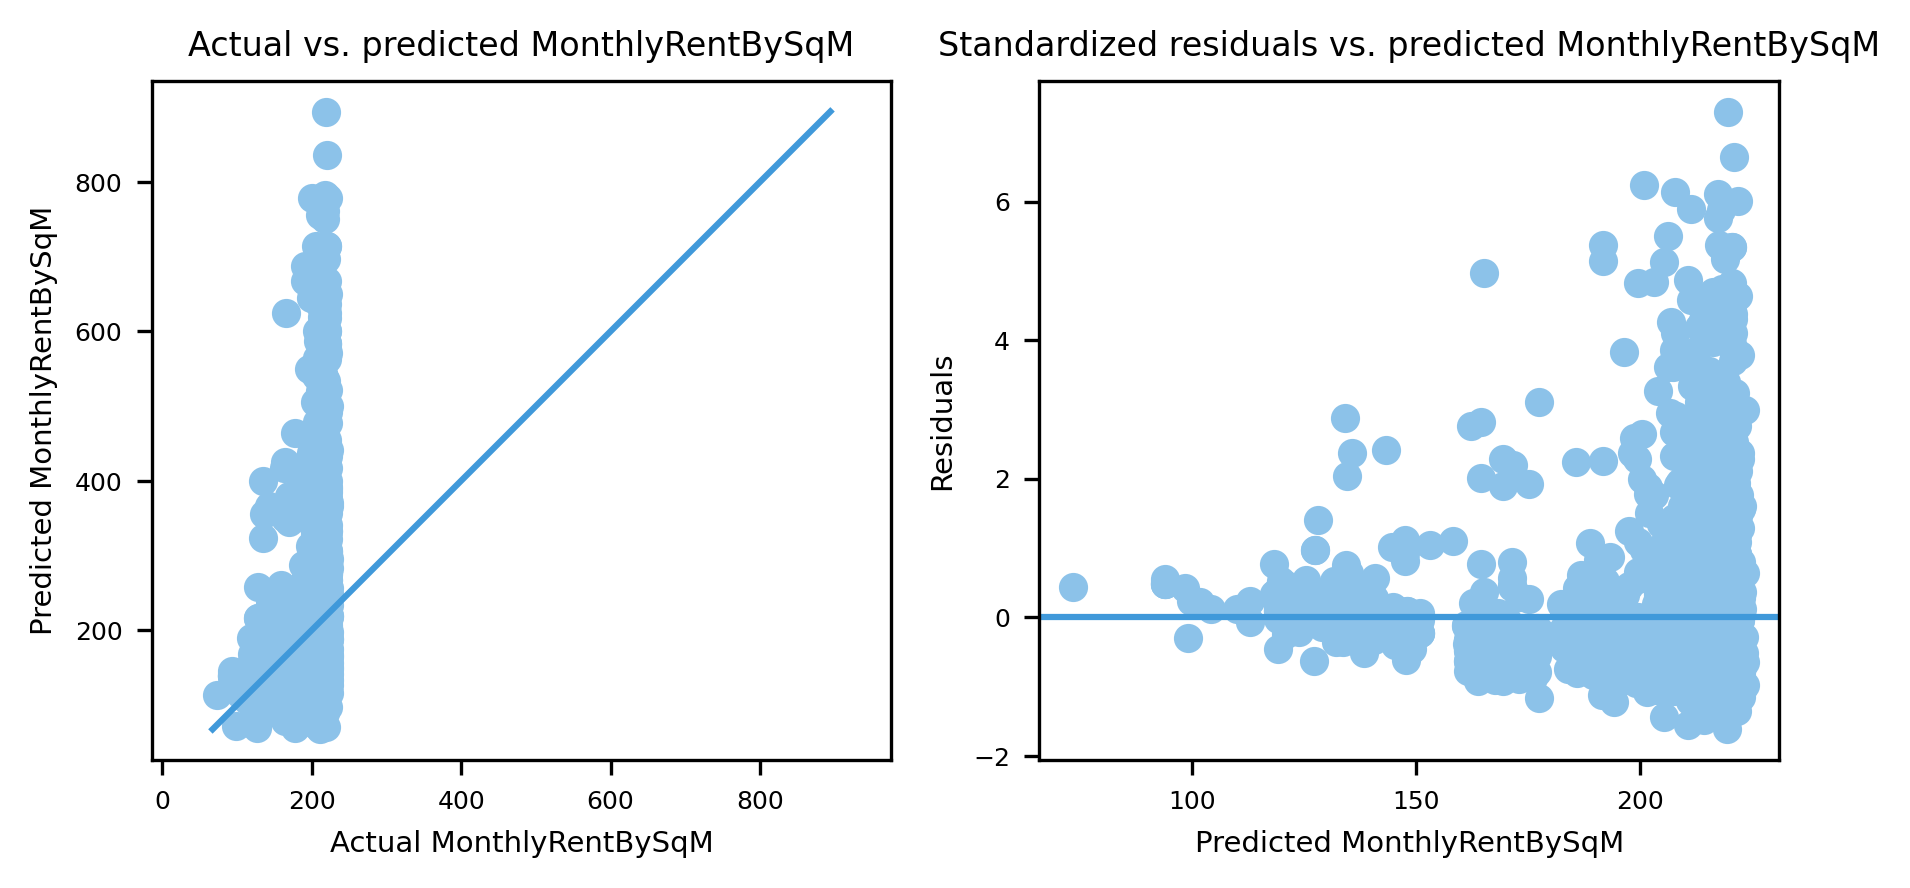

In [ ]:
FitRegressionModel("MonthlyRentBySqM ~ NearestIrmaShopKM", Accommodations)

#### H7: Scarcity in available accommodations pushes prices upwards

**Hypothesis**: Monthly rent per square meter is lower in locations where more accommodations are available for rent.

**Outcome (proved but with caution)**:
1. First of all, we discover that there are clear signs of heteroskedasticity in the model's predictions and residuals, which means that not all of the Gauss-Markov assumptions can be met. This in turn means that we should take the conclusion in point 2 with a grain of salt.
2. Second, we discover the presence of a statistically significant relationship between the number of accommodations available in a certain area and the price per square meter such that for each further accommodation available, we can expent the rent per square meter to be 0.44 kr. lower. However, it has to be noted that the model has a relatively poor fit (adj. R²=2.3%) and that its accuracy decreases as the rent price gets higher.

Testing OLS model with the following specification:
MonthlyRentBySqM ~ EntriesForLocationL1 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     105.2
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           2.73e-24
Time:                        10:08:33   Log-Likelihood:                -18155.
No. Observations:                3034   AIC:                         3.631e+04
Df Residuals:                    3032   BIC:                         3.633e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

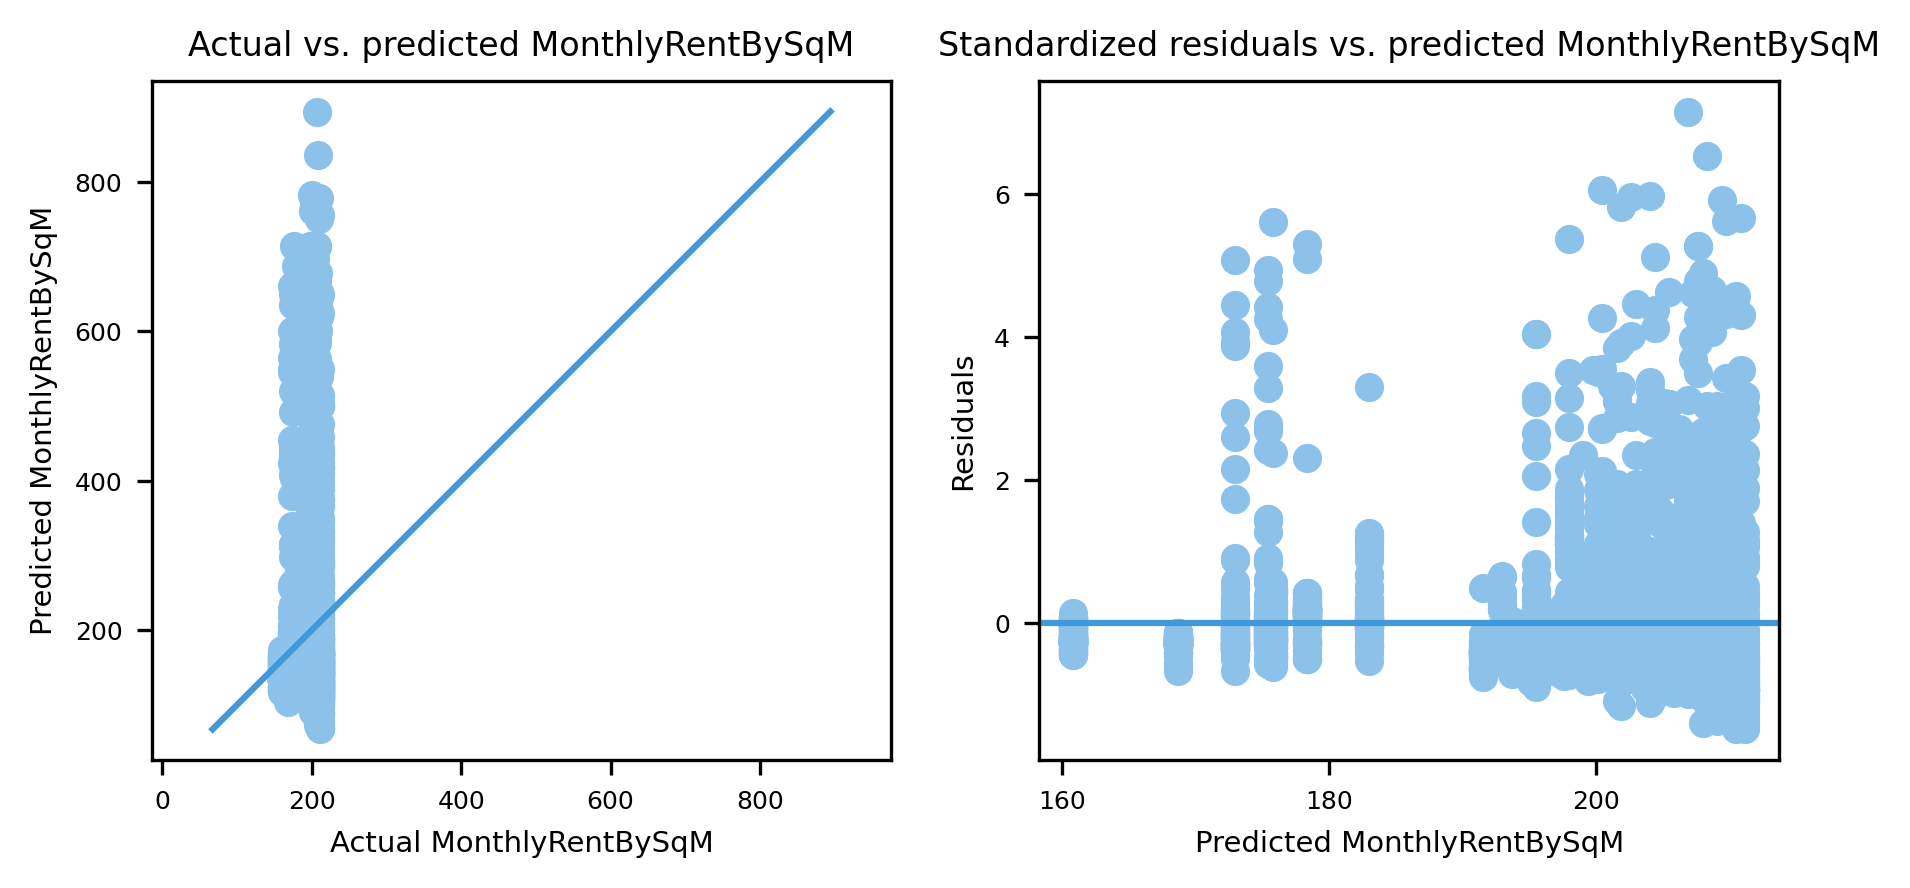

In [ ]:
# Calculating additional columns for answering this specific question
Accommodations["LatitudeL1"] = np.round(Accommodations["Latitude"], 2)
Accommodations["LongitudeL1"] = np.round(Accommodations["Longitude"], 2)

# Aggregating data on number of listings for each location (at different levels)
Accommodations["EntriesForLocationL1"] = Accommodations.groupby(["LatitudeL1", "LongitudeL1"])["Link"].transform("nunique")

# Fitting a regression model
FitRegressionModel("MonthlyRentBySqM ~ EntriesForLocationL1", Accommodations)

#### H8: Keeping pets will cost you more... even in rent!

**Hypothesis**: Monthly rent per square meter is higher in accommodations where keeping pets is allowed.

**Outcome (rejected)**:
1. As we're testing a model where the only predictor is a binary variable (`PetsAllowed`), we get a model with a relatively poor fit (adj. R²=9.3%) and exploring the usual plots is not very informative.
2. Nevertheless, we still unveal a statistically significant relationship between `MonthlyRentBySqm` and `PetsAllowed`, with accommodations allowing pets to be kept expected to cost about 60.06 kr. less on average (per square meter).
3. This is contrary to our expectation and is likely related to the fact that accommodations that allow pets are more likely to be bigger and located farther away from the city, which are factors that are both related to a lower price per square meter as revealed both by the exploratory analysis and by the results in the models we tested under the preceding hypotheses.

Testing OLS model with the following specification:
MonthlyRentBySqM ~ PetsAllowed 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     370.1
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           6.38e-78
Time:                        10:08:34   Log-Likelihood:                -18043.
No. Observations:                3034   AIC:                         3.609e+04
Df Residuals:                    3032   BIC:                         3.610e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

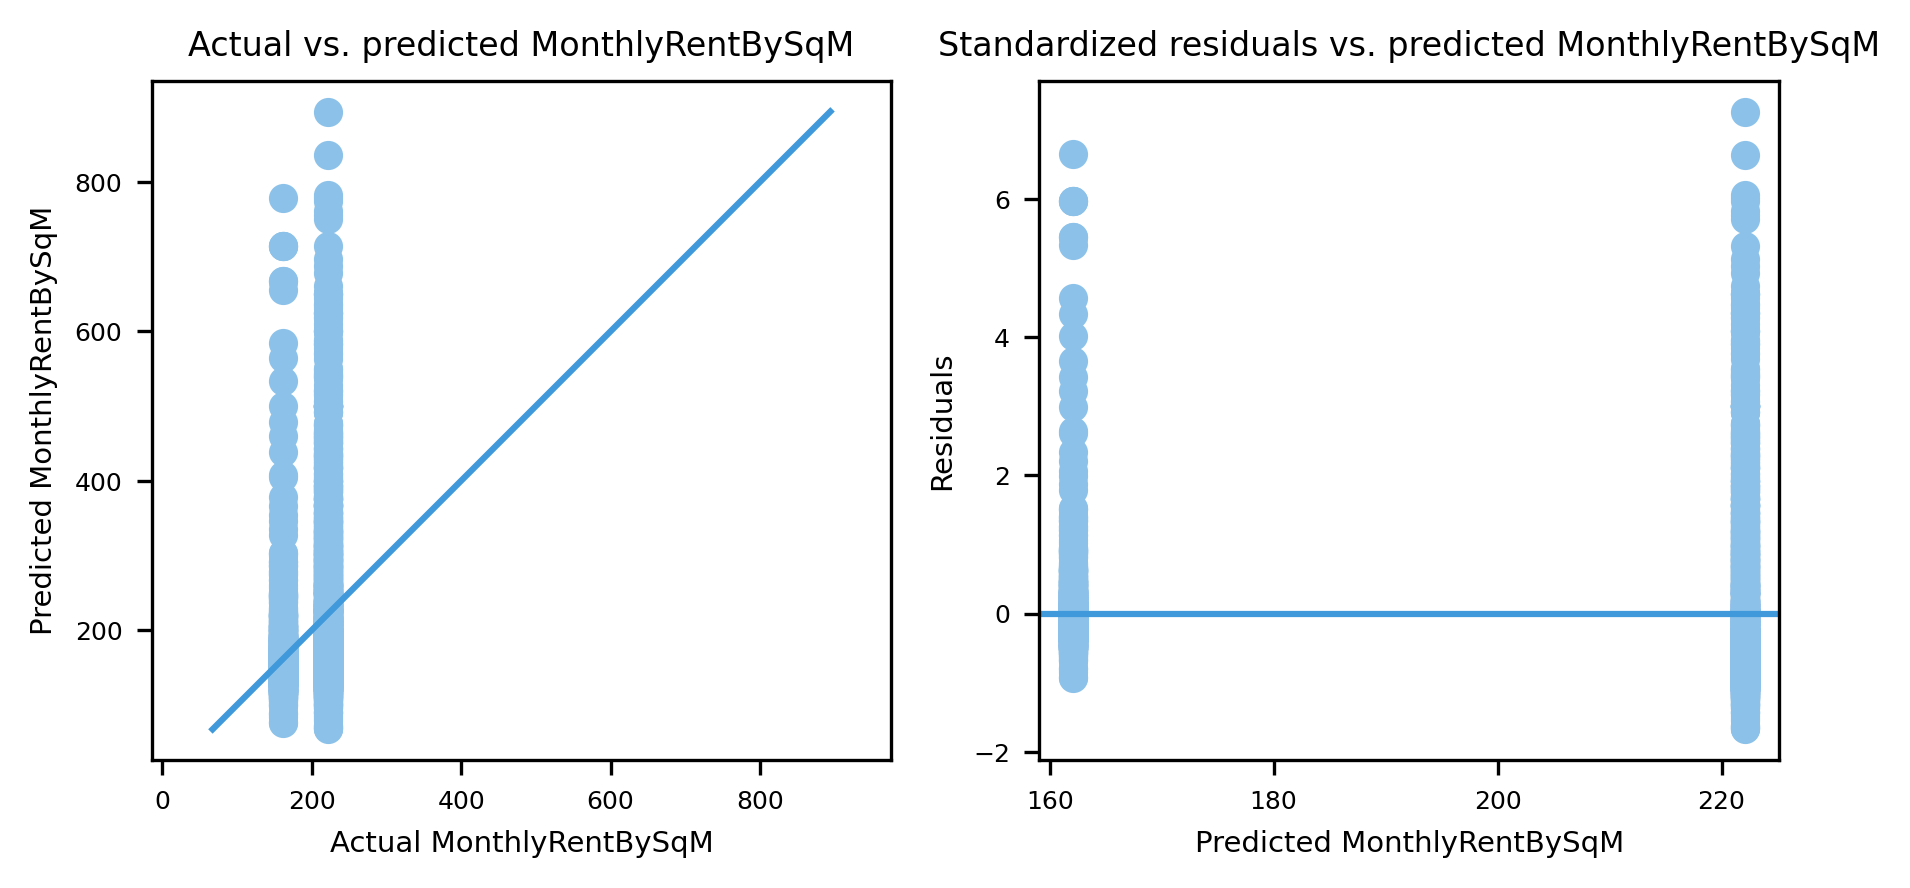

In [ ]:
FitRegressionModel("MonthlyRentBySqM ~ PetsAllowed", Accommodations)

#### H9: Places where you can park your car are pricier

**Hypothesis**: Monthly rent per square meter is higher in accommodations where parking is available.

**Outcome (rejected)**:
1. As we're testing a model where the only predictor is a binary variable (`Parking`), we get a model with a relatively poor fit (adj. R²=2.7%) and exploring the usual plots is not very informative.
2. Nevertheless, we still unveal a statistically significant relationship between `MonthlyRentBySqm` and `Parking`, with accommodations where parking is available expected to cost about 32.18 kr. less on average (per square meter).
3. This is contrary to our expectation and is likely related to the fact that accommodations where parking is available are more likely to be bigger and located farther away from the city, which are factors that are both related to a lower price per square meter as revealed both by the exploratory analysis and by the results in the models we tested under the preceding hypotheses.

Testing OLS model with the following specification:
MonthlyRentBySqM ~ Parking 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     90.55
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           3.54e-21
Time:                        10:08:35   Log-Likelihood:                -18150.
No. Observations:                3034   AIC:                         3.630e+04
Df Residuals:                    3032   BIC:                         3.632e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

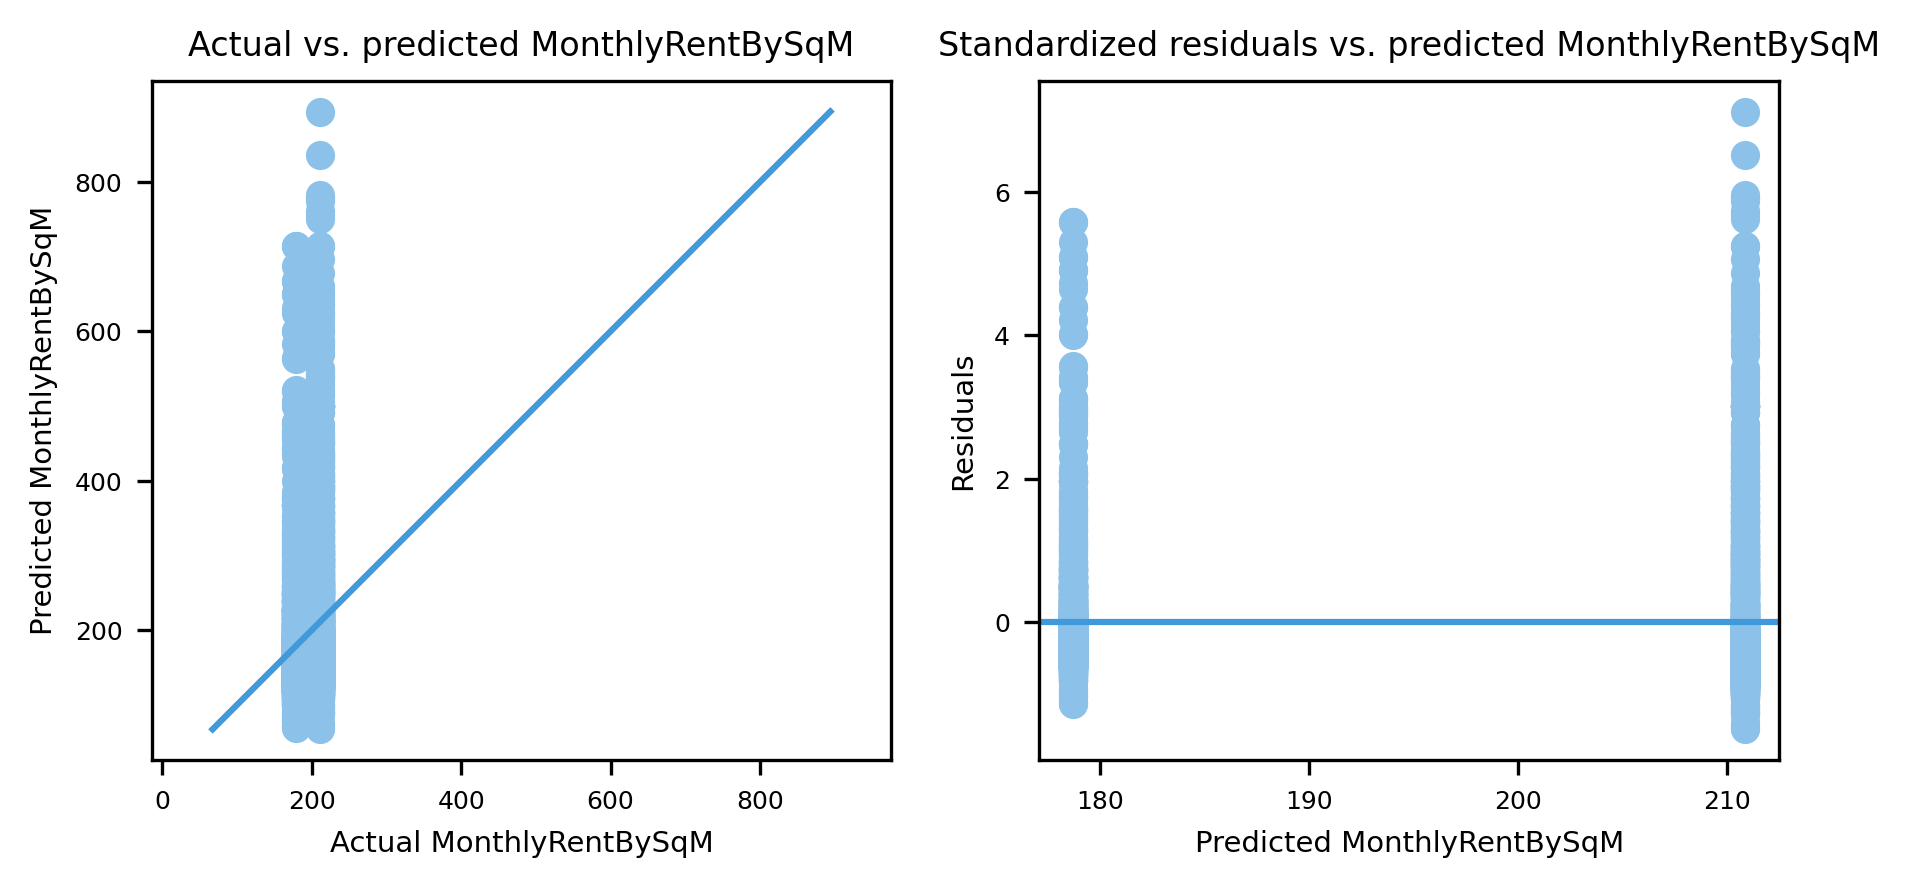

In [ ]:
FitRegressionModel("MonthlyRentBySqM ~ Parking", Accommodations)

#### H10: Short-term accommodations are pricier than long-term offerings

**Hypothesis**: Monthly rent per square meter is cheaper for accommodations which are available for longer-term rent.

**Outcome (proved)**:
1. As we're testing a model where the only predictor is a categorical variable (`RentalPeriod` or `RentalPeriodNum`), we get a model with a relatively poor fit (max adj. R²=5.8%) and exploring the usual plots is not very informative.
2. Nevertheless, we discover a statistically significant relationship between `RentalPeriod` and `MonthlyRentBySqM` and this applies to all three periods that are longer than 12 months.
3. By far, you can expect to get the largest reduction in rent per square meter if you go for an accommodation which is available for an unlimited time period. That is expected to cost you 81.18 kr. less than a corresponding accommodation that is only available for between 1-11 months. Even choosing an accommodtion that is available for 12-23 months is expected to save you 54.31 kr. per square meter on average.

Testing OLS model with the following specification:
MonthlyRentBySqM ~ RentalPeriodNum 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     88.22
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           1.12e-20
Time:                        10:08:35   Log-Likelihood:                -18108.
No. Observations:                3034   AIC:                         3.622e+04
Df Residuals:                    3032   BIC:                         3.623e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

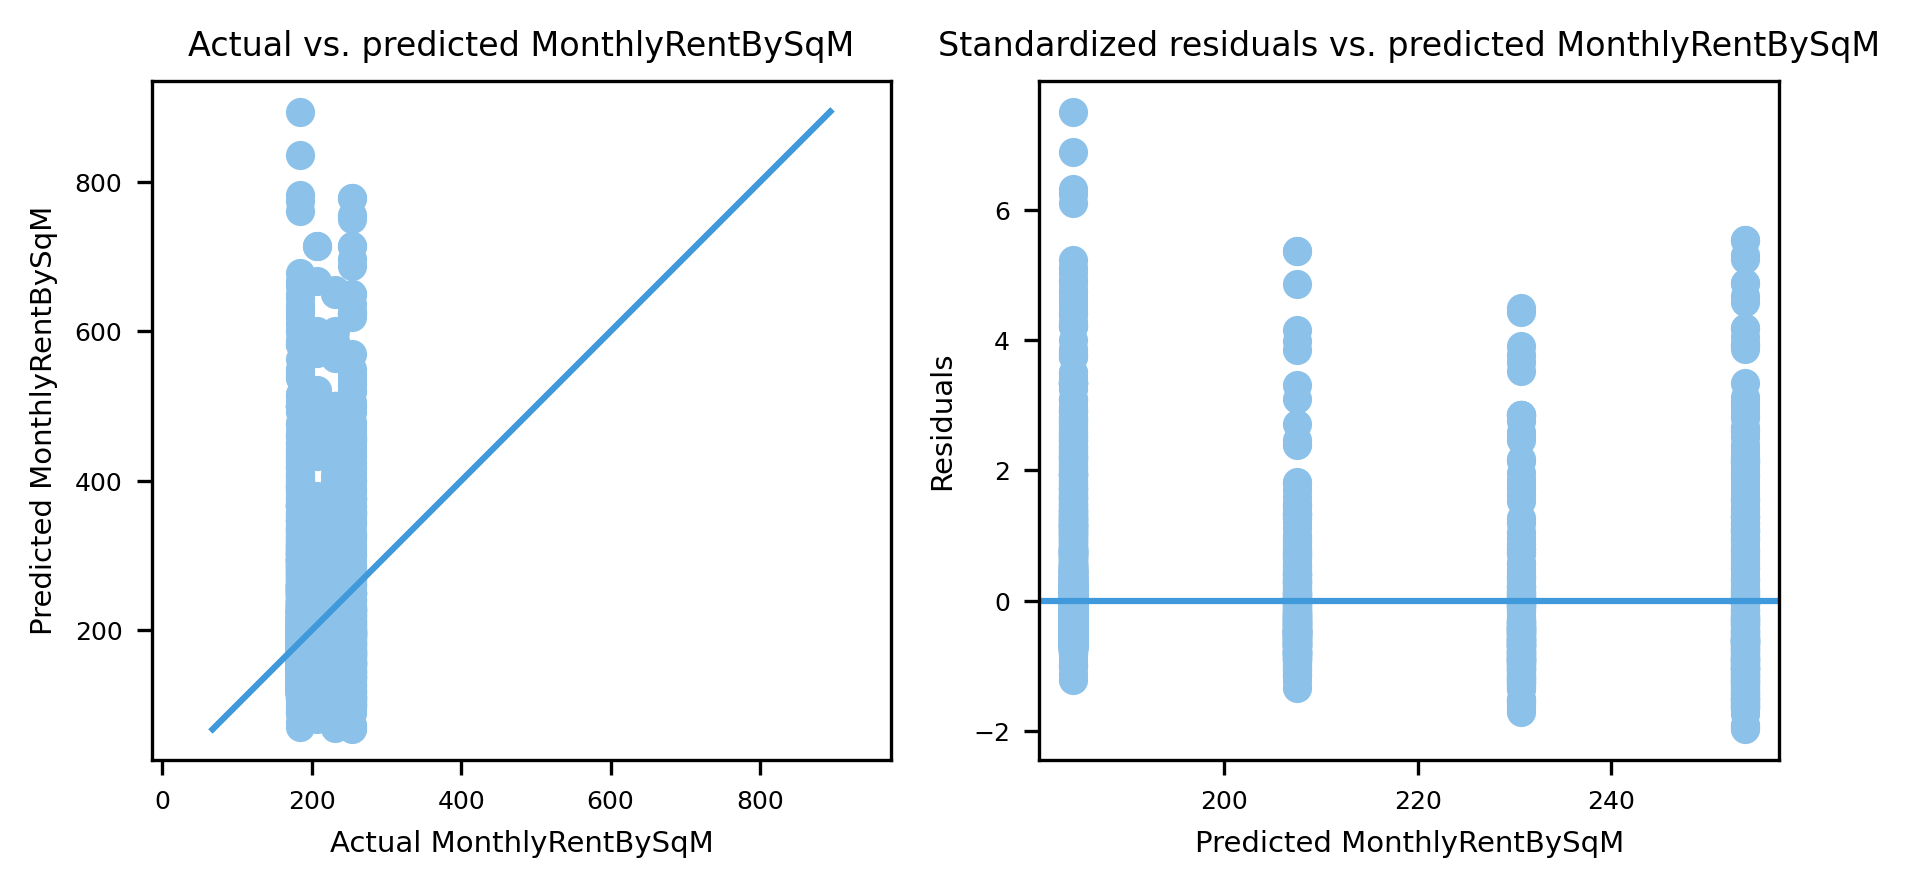

In [ ]:
# Convering the categorical variable "RentalPeriod" into a numeric one
Conditions = [(Accommodations.RentalPeriod == "1-11 months"),
              (Accommodations.RentalPeriod == "12-23 months"),
              (Accommodations.RentalPeriod == "24+ months"),
              (Accommodations.RentalPeriod == "Unlimited")]

Values = [1, 2, 3, 4]
Accommodations["RentalPeriodNum"] = np.select(Conditions, Values)

# Fitting a regression model with the "numeric" version of "RentalPeriod"
FitRegressionModel("MonthlyRentBySqM ~ RentalPeriodNum", Accommodations)

Testing OLS model with the following specification:
MonthlyRentBySqM ~ RentalPeriod 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     29.91
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           4.75e-19
Time:                        10:08:36   Log-Likelihood:                -18100.
No. Observations:                3034   AIC:                         3.621e+04
Df Residuals:                    3030   BIC:                         3.623e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

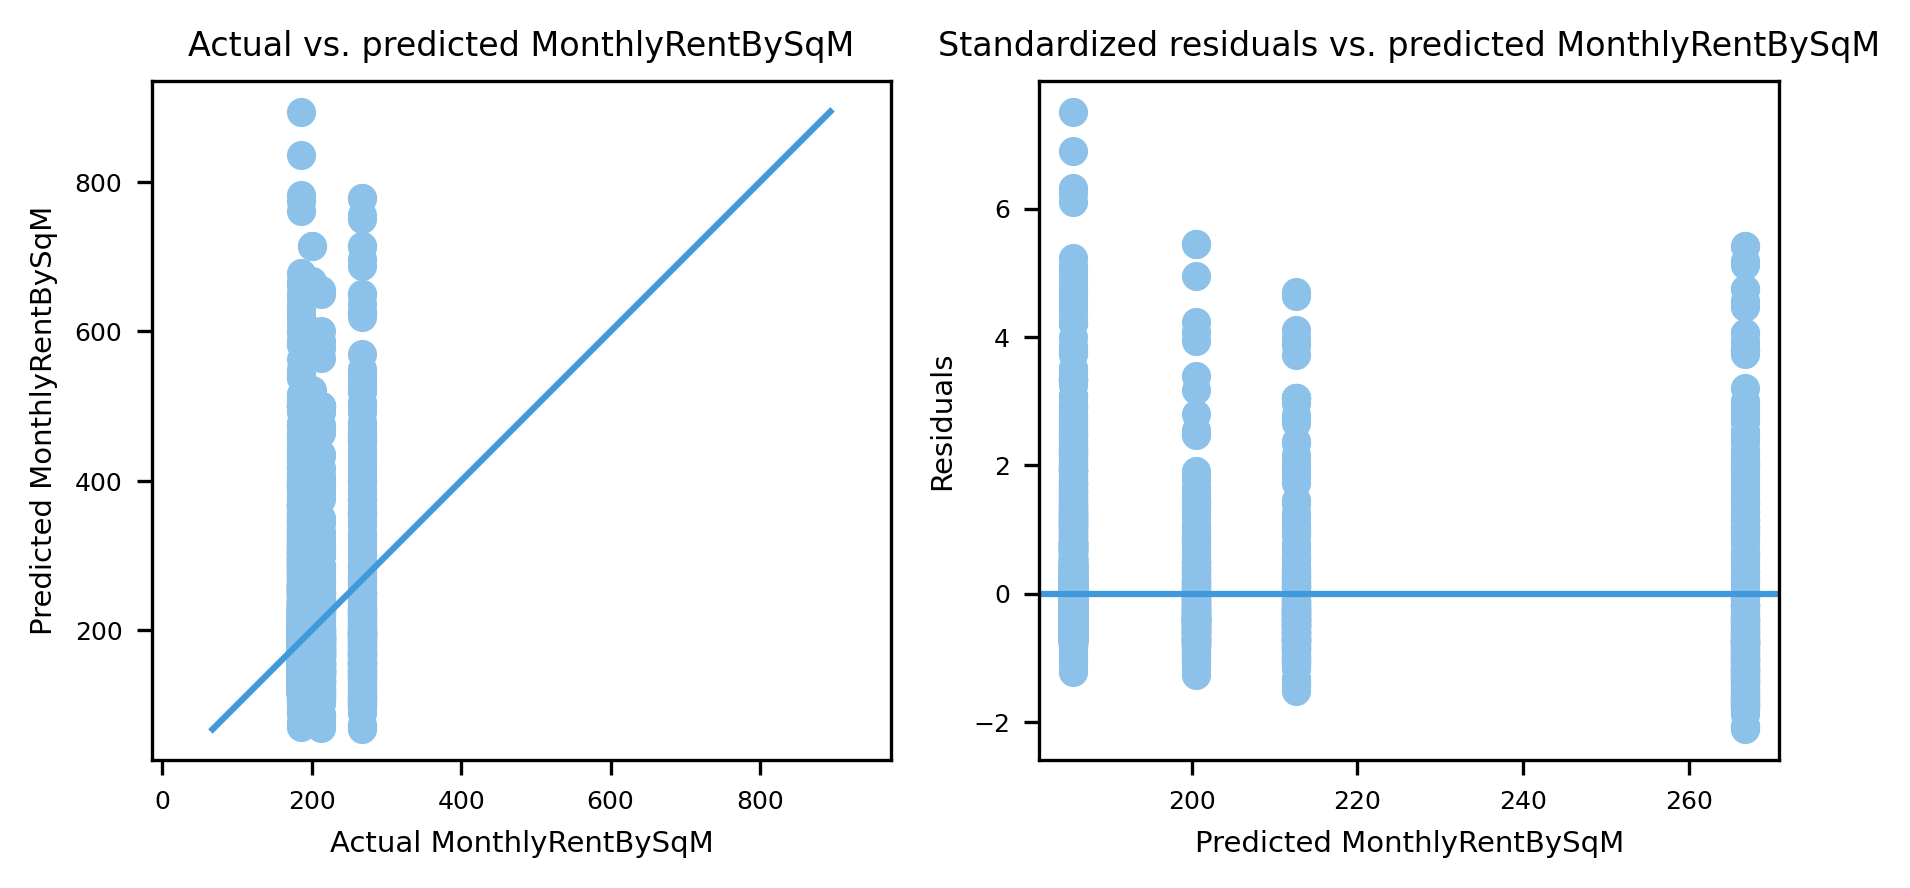

In [ ]:
# Fitting a regression model with the categorical version of "RentalPeriod"
FitRegressionModel("MonthlyRentBySqM ~ RentalPeriod", Accommodations)

#### H11: You'll pay less for having better energy efficiency

**Hypothesis**: Monthly rent per square meter is cheaper for accommodations with a lower energy efficiency rating (energy rating can be a sign of how old the building is - with older buildings assumed to be less expensive to live in than new ones, not least due to Danish legislation).

**Outcome (proved but with caution)**:
1. We find some evidence of the energy rating having a positive impact on rent prices per sqm, with better energy ratings (represented by a lower numerical value in `EnergyRatingNum`) being associated with a lower rent, a difference of about 4.72 kr. when jumping to the next-in-line better energy rating.
2. However, the fit of the model is very, very poor, as it can be judged by both its very low adj. R²=0.4% and the actuals vs. predicted plot, where we see quite a lot of variation (not to mention the very clear indications of the presence of heteroskedasticity).
3. Neither the fit nor the explanatory power of the model improves if we account for the different energy ratings on their own. In this scenario, we also don't discover any consistencies of how energy ratings affect rent prices, with only two energy ratings having a significant impact on rent prices: `C` (associated with a pricier rent) and `G` (associated with a cheaper rent).

Testing OLS model with the following specification:
MonthlyRentBySqM ~ EnergyRatingNum 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     10.23
Date:                Tue, 21 Feb 2023   Prob (F-statistic):            0.00139
Time:                        10:08:37   Log-Likelihood:                -18185.
No. Observations:                3034   AIC:                         3.637e+04
Df Residuals:                    3032   BIC:                         3.639e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

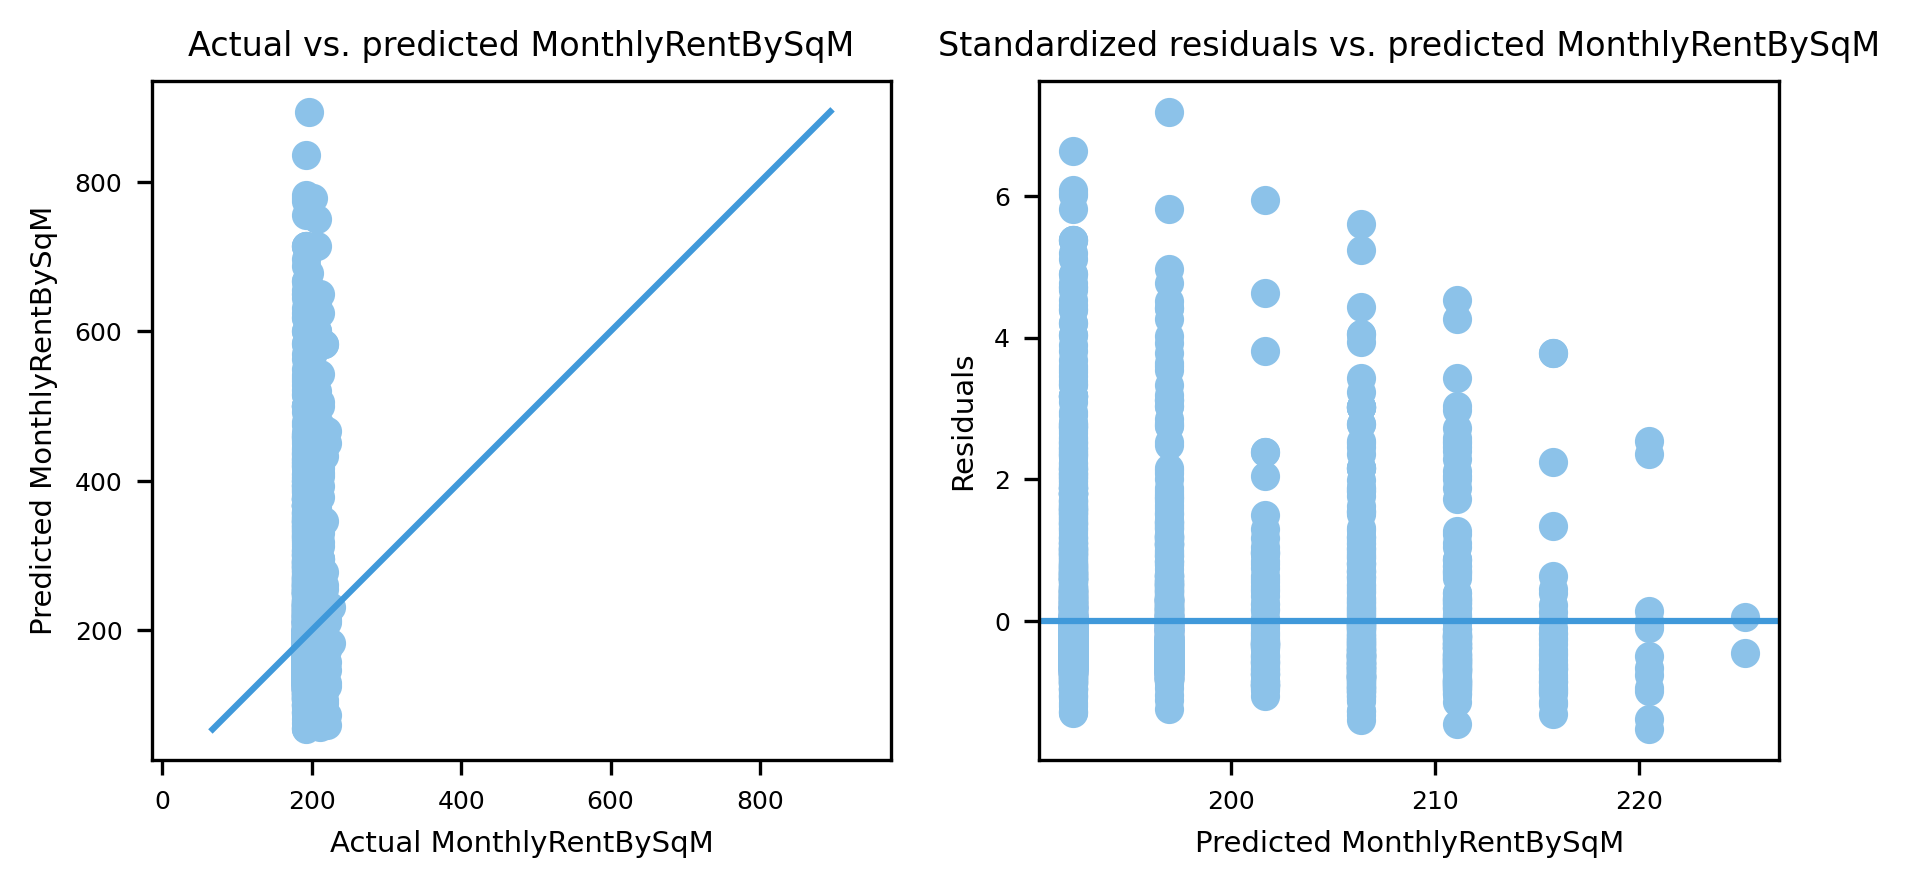

In [ ]:
# Convering the categorical variable "EnergyRating" into a numeric one
# We assume that all "A--" ratings are relatively similar compared to the other ratings
Conditions = [(Accommodations.EnergyRating.isin(["A10", "A15", "A20"])),
              (Accommodations.EnergyRating == "B"),
              (Accommodations.EnergyRating == "C"),
              (Accommodations.EnergyRating == "D"),
              (Accommodations.EnergyRating == "E"),
              (Accommodations.EnergyRating == "F"),
              (Accommodations.EnergyRating == "G"),
              (Accommodations.EnergyRating == np.nan)]

Values = [1, 2, 3, 4, 5, 6, 7, np.nan]
Accommodations["EnergyRatingNum"] = np.select(Conditions, Values)

# Fitting a regression model with the "numeric" version of "EnergyRating"
FitRegressionModel("MonthlyRentBySqM ~ EnergyRatingNum", Accommodations)

Testing OLS model with the following specification:
MonthlyRentBySqM ~ EnergyRatingB + EnergyRatingC + EnergyRatingD + EnergyRatingE + EnergyRatingF + EnergyRatingG 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.745
Date:                Tue, 21 Feb 2023   Prob (F-statistic):             0.0116
Time:                        10:08:38   Log-Likelihood:                -18181.
No. Observations:                3034   AIC:                         3.638e+04
Df Residuals:                    3027   BIC:                         3.642e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                    coef    std err        

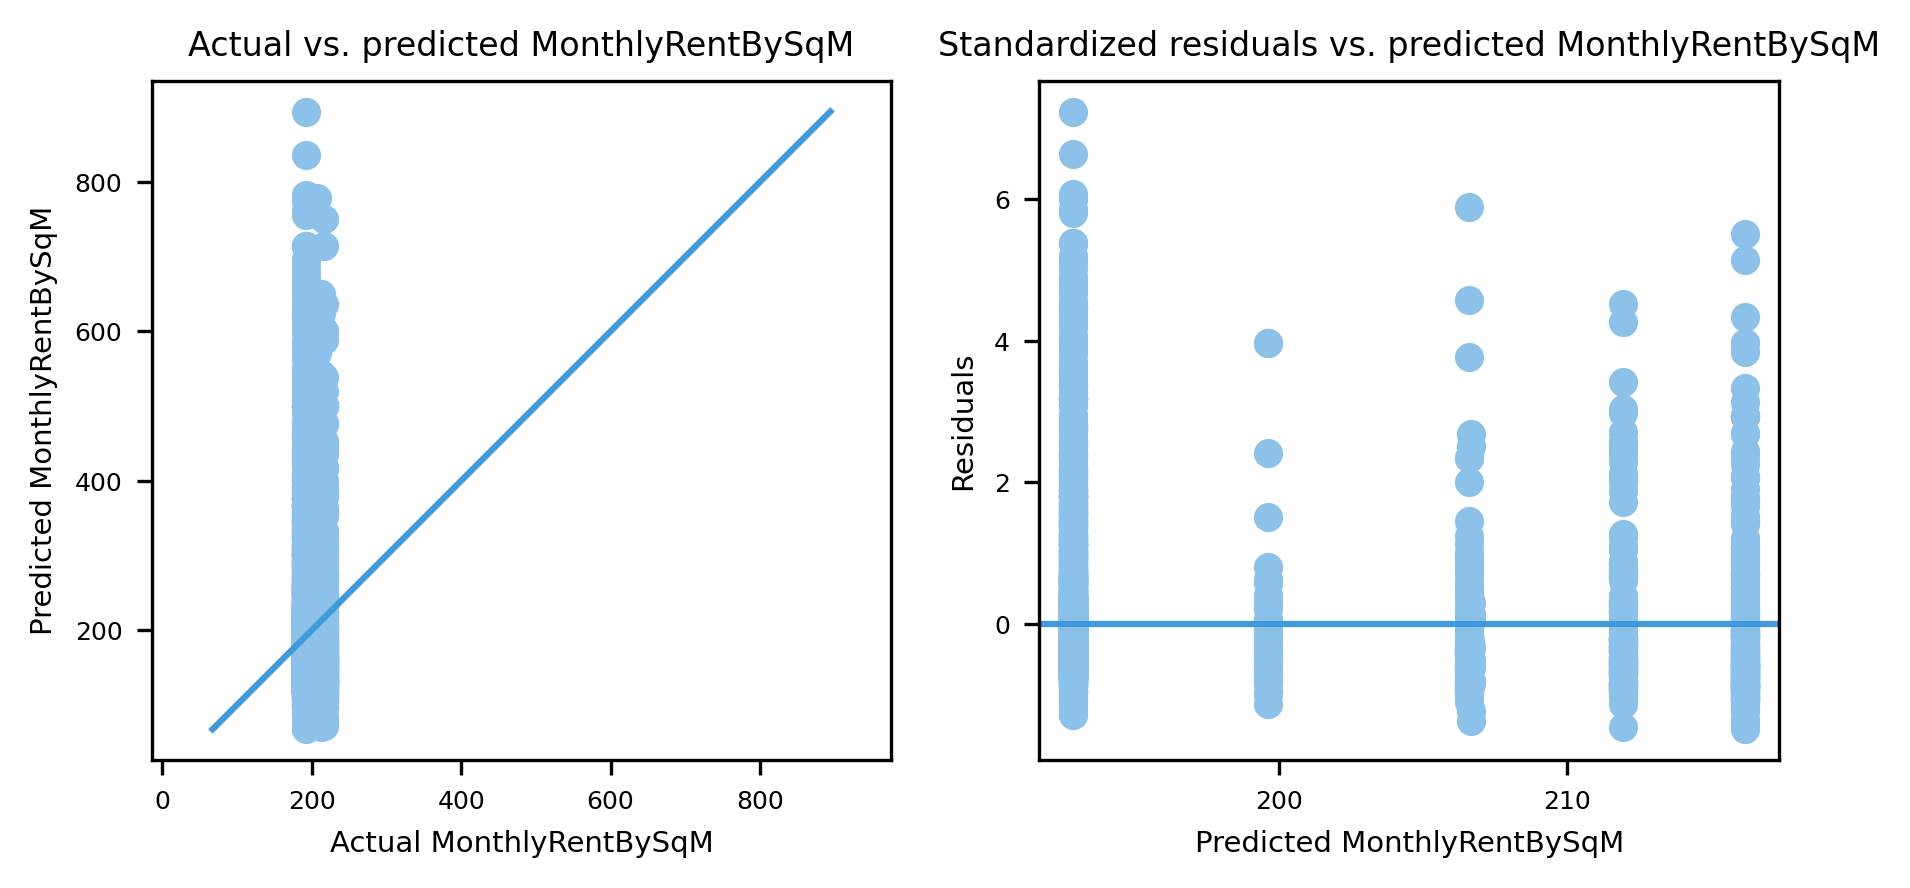

In [ ]:
# Fitting a regression model with the categorical version of "EnergyRating"
TempData = Accommodations.copy()
TempData["EnergyRating"] = np.where(TempData["EnergyRating"].isin(["A10", "A15", "A20"]), "A", TempData["EnergyRating"])

# Creating individual boolean variables so we can decide on our own which one to exclude from the model
TempData["EnergyRatingA"] = (TempData["EnergyRating"] == "A").astype(float)
TempData["EnergyRatingB"] = (TempData["EnergyRating"] == "B").astype(float)
TempData["EnergyRatingC"] = (TempData["EnergyRating"] == "C").astype(float)
TempData["EnergyRatingD"] = (TempData["EnergyRating"] == "D").astype(float)
TempData["EnergyRatingE"] = (TempData["EnergyRating"] == "E").astype(float)
TempData["EnergyRatingF"] = (TempData["EnergyRating"] == "F").astype(float)
TempData["EnergyRatingG"] = (TempData["EnergyRating"] == "G").astype(float)

# Fitting the model
FitRegressionModel("MonthlyRentBySqM ~ EnergyRatingB + EnergyRatingC + EnergyRatingD + EnergyRatingE + EnergyRatingF + EnergyRatingG", TempData)

#### H12: You'll pay a different price for houses than for apartments etc.

**Hypothesis**: Monthly rent per square meter is significantly different for accommodaitons of different types (e.g. single rooms vs. complete accommodations).

**Outcome (proved for apartments and rooms)**:
1. Surprisingly (given the small amount of information we're basing our model off), the model is so good it can already explain about 50% of what's driving the variation in rent per sqm! Although some of the Gauss-Markov assumptions are not likely met, judging by the plot below.
2. We don't find any evidence of houses having significanlty different rent prices, though we find that apartments are on average 35 kr. more expensive than other kinds of accommodations (per sqm).
3. Shockingly, we also find very strong evidence that rooms are more than 239 kr. (!!!) more expensive per square meter than other kinds of accommodations. This may suggest some form of abuse on behalf of landlords as they're obviously making a lot more money on a lot fewer square meters.

Testing OLS model with the following specification:
MonthlyRentBySqM ~ Apartment + House + Room 

                            OLS Regression Results                            
Dep. Variable:       MonthlyRentBySqM   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     304.7
Date:                Tue, 21 Feb 2023   Prob (F-statistic):          6.88e-173
Time:                        10:08:40   Log-Likelihood:                -17187.
No. Observations:                3034   AIC:                         3.438e+04
Df Residuals:                    3030   BIC:                         3.441e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

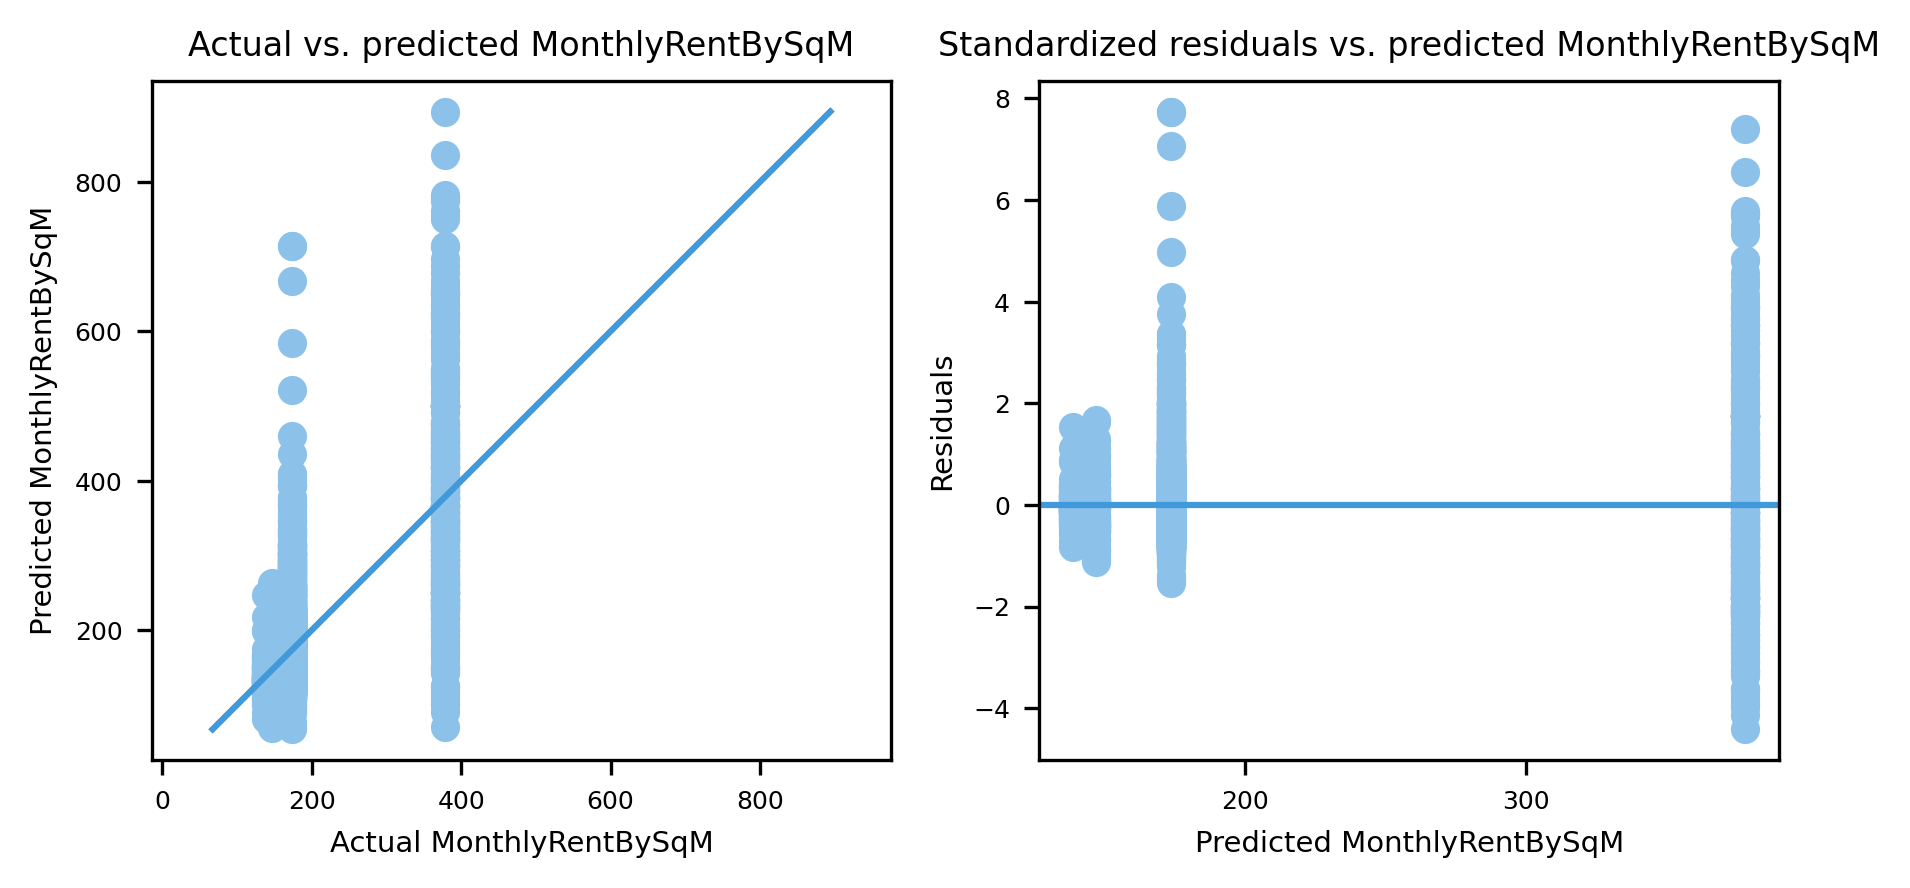

In [ ]:
TempData = Accommodations.copy()

# Creating individual boolean variables so we can decide on our own which one to exclude from the model
TempData["Apartment"] = (TempData["AccommodationType"] == "Apartment").astype(float)
TempData["House"] = (TempData["AccommodationType"] == "House").astype(float)
TempData["SemiDetachedHouse"] = (TempData["AccommodationType"] == "Semi-detached house").astype(float)
TempData["Room"] = (TempData["AccommodationType"] == "Room").astype(float)

# Fitting the model
FitRegressionModel("MonthlyRentBySqM ~ Apartment + House + Room", TempData)

## Exporting data

Within this notebook, the `Accommodations` dataset has been expanded with a series of useful additions such as e.g. distance from the nearest metro/train station etc. So as not to have to calculate these again, a copy of the enhanced dataset is exported so that it can be reused in other analyses/notebooks.

In [ ]:
# Exporting data
Accommodations.to_pickle(AnalysisFolder + "Data/AccommodationsEnhanced.pkl")
Accommodations.to_excel(AnalysisFolder + "Data/AccommodationsEnhanced.xlsx", index = False)